# Deep Learning. Materials on the book by Andrew Trask

**В этом ноутбуке расположены учебные материалы по основам DL, краткий конспект теории и код, реализующий нейронные сети различной структуры**     

**Структура ноутбука**:    
1. Введение в нейронное прогнозирование    
    1.1 Сети прямого распространения. Метод холодно/горячо, градиентный спуск. Замораживание весов            
    1.2 Полный, пакетный и стохастический градиентный спуск. Обратное распространение ошибки
2. Введение в компьютерное зрение (CV)    
    2.1 Трехслойная сеть для класификации набора данных MNIST    
    2.2 Переобучение, регуляризация, пакетный град.спуск       
    2.3 Стандартные функции активации для скрытых слоев и выходного слоя           
    2.4 Введение в сверточные нейронные сети                
3. Введение в обработку естественного языка (NLP)    
    3.1 Векторное представление слов. Тональный анализ текста  
    3.2 Подстановка пропущенных слов. Словесные аналогии      
    3.3 Bag of words         
    3.4 Реккурентные слои
4. Введение в автоматическую оптимизацию: создание фреймворка глубокого обучения   
    4.1 Введение в автоматическое вычисление градиента (autograd). Сложение в обратном распространении  
    4.2 Добавление поддержки слоев разных типов (нелинейные слои, слой с векторным представлением, слой с перекрестной энтропией, реккурентный слой)
5. Моделирование языка символов, LSTM, введение в федеративное обучение  
    5.1 Усеченное обратное распространение. Затухающие и взрывные градиенты. Ячейки LSTM (Long Short-Term Memory)  
    5.2 Глубокое обучение на конфиденциальных данных. Введение в федеративное обучение. Гомоморфное шифрование      

**Полезные материалы:**    
- <a href="https://github.com/iamtrask/Grokking-Deep-Learning/blob/master/Chapter5%20-%20Generalizing%20Gradient%20Descent%20-%20Learning%20Multiple%20Weights%20at%20a%20Time.ipynb">Репозиторий книги по Deep Learning (Andrew Trask)</a>        
- <a href="https://neerc.ifmo.ru/wiki/index.php?title=%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8_%D1%80%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9">Практика реализации нейронных сетей</a>               
- <a href="https://pytorch.org/docs/stable/nn.html">pytorch.org</a>        
- <a href="https://keras.io/layers/about-keras-layers">keras.io</a>        
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Layer">www.tensorflow.org</a>
- <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">karpathy.github.io</a>


In [484]:
# !pip install phe

In [130]:
# Импорт библиотек
import numpy as np
import pandas as pd
import sys, os, re, math, random
from collections import Counter
import codecs
import phe

# 1. Введение в нейронное прогнозирование    
    1.1 Сети прямого распространения. Метод холодно/горячо, градиентный спуск. Замораживание весов            
    1.2 Полный, пакетный и стохастический градиентный спуск. Обратное распространение ошибки

## 1.1 Сети прямого распространения. Метод холодно/горячо, градиентный спуск. Замораживание весов 

Далее будут представлены постепенно усложняющиеся разновидности нейронных сетей. Сети прямого распространения принимают входные данные и получают прогноз. Информация в них распространяется в прямом направлении.

#### Сеть прямого распространения: несколько входов - несколько выходов    
Для получения трех прогнозов вычисляется три независимых взвешенных суммы входов (скалярных произв-й)

На вход нейронной сети подается три значения:      
1) Среднее кол-во игр, проведенных игроками команды перед данной игрой (toes)
2) Текущая доля игр, окончившихся победой (wlrec)  
3) Число болельщиков (nfans)

Выполняется прогноз:  
1) победы/поражения команды   
2) эмоционального состояния игроков - печаль/радость   
3) процента травмированных членов команды

In [3]:
# Веса простой нейронной сети с тремя входами и тремя прогнозами
              # N игр, % побед, N болельщиков
weights = np.array([[0.1, 0.1, -0.3],   # травмы
                   [0.1, 0.2, 0.0],     # победа
                   [0.0, 1.3, 0.1]])    # печаль 
print(weights.T)

# Текущее состояние перед началом каждой из первых четырех игр в сезоне
toes = np.array([8.5, 9.5, 9.9, 9.0])          # Текущее среднее кол-во игр, сыгранных игроками
wlrec = np.array([0.65, 0.8, 0.8, 0.9])        # Текущая доля игр, окончившихся победой
nfans = np.array([1.2, 1.3, 0.5, 1.0])         # Число болельщиков (в млн.)

inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне

[[ 0.1  0.1  0. ]
 [ 0.1  0.2  1.3]
 [-0.3  0.   0.1]]


In [24]:
def w_sum(vect_a, vect_b):
    # Выполняет скалярное произведение векторов np.dot(vect_a, vect_b)
    assert(len(vect_a) == len(vect_b))
    output = 0
    for i in range(len(vect_a)):   
        output += vect_a[i] * vect_b[i]
    return output
    
def vect_mat_mul(vect, matrix):
    # Выполняет обход всех векторов весов и вычисляет прогноз с помощью функции w_sum
    # Последовательно находит три взвешенных суммы и сохраняет результаты в векторе output
    assert(len(vect) == len(matrix))
    output = [0, 0, 0]
    for i in range(len(vect)):
        output[i] = w_sum(vect, matrix[i])
    return output

def neural_network(inp, weights):
    pred = vect_mat_mul(inp, weights)
    return [round(i, 3) for i in pred]

pred = neural_network(inp, weights)
print(f'Прогноз вероятности травм: {pred[0]}\nПрогноз вероятности победы: {pred[1]}\nПрогноз вероятности огорчения: {pred[2]}')

Прогноз вероятности травм: 0.555
Прогноз вероятности победы: 0.98
Прогноз вероятности огорчения: 0.965


In [19]:
def neural_network(inp, weights):
    # Операция векторно-матричного умножения для вычисления серии взвешенных сумм
    # Она берет вектор и находит скалярное произведение между ним и каждой строкой в матрице
    pred = inp.dot(weights.T)  # np.dot(inp, weights.T)
    return [round(i, 3) for i in pred]

inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне    
pred_ = neural_network(inp, weights)
print(f'Прогноз вероятности травм: {pred_[0]} \nПрогноз вероятности победы: {pred_[1]} \nПрогноз вероятности огорчения: {pred_[2]}')

Прогноз вероятности травм: 0.555 
Прогноз вероятности победы: 0.98 
Прогноз вероятности огорчения: 0.965


#### Прогнозирование на основе прогнозов. Три входа, три выхода и скрытый слой

Чтобы получить прогноз, нейронные сети многократно вычисляют взвешенную сумму для входных данных.  
Выход одной сети передается на вход другой, в результате получается цепочка векторно-матричных умножений.

In [26]:
# Веса простой нейронной сети с тремя входами и тремя прогнозами
             # N игр, % побед, N болельщиков
ih_wgt = np.array([[0.1, 0.2, -0.1],    # hid[0]
                   [-0.1, 0.1, 0.9],    # hid[1]
                   [0.1, 0.4, 0.1]]).T  # hid[2]

             # hid[0], hid[1], hid[2]
hp_wgt = np.array([[0.3, 1.1, -0.3],    # травмы
                   [0.1, 0.2, 0.0],     # победа
                   [0.0, 1.3, 0.1]]).T  # печаль

weights = [ih_wgt, hp_wgt]
print(*[w for w in weights], sep = '\n\n')

# Текущее состояние перед началом каждой из первых четырех игр в сезоне
toes = np.array([8.5, 9.5, 9.9, 9.0])          # Текущее среднее кол-во игр, сыгранных игроками
wlrec = np.array([0.65, 0.8, 0.8, 0.9])        # Текущая доля игр, окончившихся победой
nfans = np.array([1.2, 1.3, 0.5, 1.0])         # Число болельщиков (в млн.)

inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне  

[[ 0.1 -0.1  0.1]
 [ 0.2  0.1  0.4]
 [-0.1  0.9  0.1]]

[[ 0.3  0.1  0. ]
 [ 1.1  0.2  1.3]
 [-0.3  0.   0.1]]


In [27]:
def neural_network(inp, weights):
    hid = inp.dot(weights[0])    # np.dot(inp, weights[0])
    pred = hid.dot(weights[1])   # np.dot(hid, weights[1])
    return [round(i, 3) for i in pred]

pred = neural_network(inp, weights)
print(f'Прогноз вероятности травм: {pred[0]}\nПрогноз вероятности победы: {pred[1]}\nПрогноз вероятности огорчения: {pred[2]}')

Прогноз вероятности травм: 0.214
Прогноз вероятности победы: 0.145
Прогноз вероятности огорчения: 0.506


#### Обучение методом 'холодно/горячо'  (простой способ, но неэффективный)
Обучение нейронной сети - поиск комбинации весов, при которой ошибка сети снизится до минимума и будет обеспечена достоверность предсказания.    
Это процесс определения причин ошибок, искусство выяснения вклада каждого веса в общую ошибку.   
Цель обучения нейронной сети - получение достоверных прогнозов.       


**Метод 'холодно/горячо'** предполагает изменение весов в разных направлениях, чтобы определить, какое из них ведет к наибольшему уменьшению ошибки, корректировку весов в этом направлении и повторение процедуры сначала, пока ошибка не достигнет минимума. Этот метод неэффективен, поскольку требуется вычислять проноз несколько раз, чтобы один раз изменить значение весов. Другая проблема в том, что зная правильное направление для изменения веса, мы не знаем правильной величины этого изменения и выбираем произвольное значение шага (step_amount). Кроме того, эта величина никак не связана с ошибкой.

Простая сеть - получение одного прогноза (вероятность победы команды) с одним входом (текущая доля выигранных поединков)

In [28]:
weight = inp = 0.5
goal_pred = 0.8
step_amount = 0.001  # Шаг изменения веса в каждой итерации

def simple_neuronet(inp, weight, goal_pred, step_amount):  # Обучение методом 'холодно/горячо'  
    for iteration in range(1101):
        pred = inp * weight
        error = (pred - goal_pred)**2
        if not iteration % 100: print(f'Error: {round(error, 5)}. Prediction: {round(pred, 4)}')

        up_pred = inp * (weight + step_amount)  # Увеличиваем вес
        up_error = (goal_pred - up_pred)**2
        down_pred = inp * (weight - step_amount)  # Уменьшаем вес
        down_error = (goal_pred - down_pred)**2

        if down_error < up_error: weight -= step_amount
        else: weight += step_amount
        
simple_neuronet(inp, weight, goal_pred, step_amount)  # На последнем шаге получен точный прогноз

Error: 0.3025. Prediction: 0.25
Error: 0.25. Prediction: 0.3
Error: 0.2025. Prediction: 0.35
Error: 0.16. Prediction: 0.4
Error: 0.1225. Prediction: 0.45
Error: 0.09. Prediction: 0.5
Error: 0.0625. Prediction: 0.55
Error: 0.04. Prediction: 0.6
Error: 0.0225. Prediction: 0.65
Error: 0.01. Prediction: 0.7
Error: 0.0025. Prediction: 0.75
Error: 0.0. Prediction: 0.8


#### Градиентный спуск. Замораживание весов
- **Нейронные сети** - наборы весовых коэффициентов, используемых для вычисления функций ошибки. Для любой ошибки можно вычислить отношение между любым весом и окончательной ошибкой сети. Обучение фактически сводится к корректировке весов для минимизации ошибки. Решение задачи заключается в понимании взаимосвязи между весом и ошибкой. Необходимо понимать насколько чувствительна ошибка к изменению weights.
- **Градиентный спуск** позволяет вычислить для каждого веса некоторое число, определяющее, насколько этот вес должен быть выше или ниже, чтобы уменьшить ошибку. После этого необходимо уменьшить \ увеличить весовой коэффициент. В процессе град. спуска мы перемещаем значение веса в направлении, противоположном значению градиента и приближаем ошибку к минимуму (Градиент - вектор из частных производных по всем направлениям). Градиентный спуск - это итеративный оптимизационный алгоритм для нахождения локального минимума функции. Шаг обновления весов задаётся с помощью обучающего коэффициента (learning rate). 
- **Разница между ошибкой и производной от ошибки и веса** состоит в том, что *ошибка* определяет величину промаха сети (разность delta=pred-true, на которую желательно скорректировать выходное значение), а *производная* определяет отношение между каждым весом и величиной промаха. Производная сообщает, какой вклад вносит в ошибку изменение веса. Это оценка величины и направления смещения веса для уменьшения разности delta.  
- **Производная** tg(a) описывает связь между двумя переменными в функции и позволяет узнать, насколько изменится одна переменная при изменении другой (чувствительность одной переменной к изменению другой). Положительный знак производной - переменные изменяются в одном направлении, отрицательный - переменные изменяются в разных направлениях, нулевая чувствительность - изменение одной переменной никак не отражается на другой. Для корректировки весов необходимо двигаться в направлении противоположном производной, делать шаги в направлении минимума функции.    
- **Шаг обучения (learning rate \ alpha)**. Если входное значение достаточно велико, небольшое изменение веса может вызвать значительное изменение в прогнозе даже при маленьком значении ошибки. Ошибка очень чувствительна к весу. При расхождениии весов величина производной в новой точке превосходит величину прежней производной (хоть и с др. знаком). Самым простым решением проблемы является использование шага обучения (learning rate или alpha), он позволяет избежать избыточной коррекции весов (расхождения).  
- weight = weight - alpha * (input * (pred - goal_pred))

Простая сеть: получение одного прогноза (вероятность победы команды) с одним входом (текущая доля выигранных поединков) с использованием град.спуска  


In [29]:
# Градиентный спуск позволяет вычислить сразу направление и величину изменения веса для уменьшения ошибки
inp, weight, goal_pred, alpha  = [2, 0.5, 0.8, 0.1]

def simple_grad_neuronet(inp, weight, goal_pred, alpha):
    for iteration in range(20):
        pred = inp * weight
        error = (pred - goal_pred)**2
        derivative = inp * (pred - goal_pred) 
        # derivative определяет величину изменения веса, обусловленную промахом сети
        # Масштабирование разности на выходе взвешиваемым входом (масштабирование, обращение знака, остановка)
        weight = weight - (alpha * derivative)
        print(f'Error: {round(error, 8)}. Prediction: {round(pred, 6)}')
simple_grad_neuronet(inp, weight, goal_pred, alpha)  # На последних итерациях получен точный прогноз

Error: 0.04. Prediction: 1.0
Error: 0.0144. Prediction: 0.92
Error: 0.005184. Prediction: 0.872
Error: 0.00186624. Prediction: 0.8432
Error: 0.00067185. Prediction: 0.82592
Error: 0.00024186. Prediction: 0.815552
Error: 8.707e-05. Prediction: 0.809331
Error: 3.135e-05. Prediction: 0.805599
Error: 1.128e-05. Prediction: 0.803359
Error: 4.06e-06. Prediction: 0.802016
Error: 1.46e-06. Prediction: 0.801209
Error: 5.3e-07. Prediction: 0.800726
Error: 1.9e-07. Prediction: 0.800435
Error: 7e-08. Prediction: 0.800261
Error: 2e-08. Prediction: 0.800157
Error: 1e-08. Prediction: 0.800094
Error: 0.0. Prediction: 0.800056
Error: 0.0. Prediction: 0.800034
Error: 0.0. Prediction: 0.80002
Error: 0.0. Prediction: 0.800012


#### Корректировка сразу нескольких весов градиентным спуском. Несколько входов - один выход
Предсказание вероятности победы команды по трем значениям:
1) Текущее среднее кол-во игр, сыгранных игроками (toes)
2) Текущая доля игр, окончившихся победой (wlrec)
3) Число болельщиков (nfans)

In [42]:
# Градиентный спуск позволяет вычислить сразу и направление, и величину изменения веса для уменьшения ошибки
weights = [0.1, 0.2, -0.1]
alpha = 0.01

win_or_lose_binary = [1, 1, 0, 1]
true = win_or_lose_binary[0] 

# Текущее состояние перед началом каждой из первых четырех игр в сезоне
toes = np.array([8.5, 9.5, 9.9, 9.0])          # Текущее среднее кол-во игр, сыгранных игроками
wlrec = np.array([0.65, 0.8, 0.8, 0.9])        # Текущая доля игр, окончившихся победой
nfans = np.array([1.2, 1.3, 0.5, 1.0])         # Число болельщиков (в млн.)

# Входные значения и истинный прогноз
inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне 
true = win_or_lose_binary[0] 

def neural_network(inp, weights):
    # return np.dot(inp, weights)
    out = 0
    for i in range(len(inp)):
        out += inp[i] * weights[i]
    return out

def ele_mul(scalar, vector):  
    #  return np.dot(scalar, vector)
    out = [0, 0, 0]
    for i in range(len(out)):
        out[i] = vector[i] * scalar
    return out

for iteration in range(3):
    pred = neural_network(inp, weights)
    error = (pred - true)**2
    delta = pred - true
    weight_deltas = ele_mul(delta, inp)        
    
    print(f'Iteration: {iteration + 1}')
    print(f'Prediction: {round(pred, 4)}')
    print(f'Error: {round(error, 4)}')
    print(f'Delta: {round(delta, 4)}')
    print(f'Weights: {weights}')
    print(f'Weight_deltas: {weight_deltas}')
    print()   
    for i in range(len(weights)):
        weights[i] -= alpha * weight_deltas[i]   

Iteration: 1
Prediction: 0.86
Error: 0.0196
Delta: -0.14
Weights: [0.1, 0.2, -0.1]
Weight_deltas: [-1.189999999999999, -0.09099999999999994, -0.16799999999999987]

Iteration: 2
Prediction: 0.9638
Error: 0.0013
Delta: -0.0362
Weights: [0.1119, 0.20091, -0.09832]
Weight_deltas: [-0.30806125000000056, -0.023557625000000044, -0.04349100000000008]

Iteration: 3
Prediction: 0.9906
Error: 0.0001
Delta: -0.0094
Weights: [0.11498061250000001, 0.20114557625, -0.09788509000000001]
Weight_deltas: [-0.07974935609374867, -0.006098480171874899, -0.011258732624999811]



#### Замораживание весов   
#### Замораживание одного веса. Градиентный спуск. Несколько входов - один выход   

Предсказание вероятности победы команды по трем значениям (с замораживанием первого веса):
1) Текущее среднее кол-во игр, сыгранных игроками (toes)
2) Текущая доля игр, окончившихся победой (wlrec)
3) Число болельщиков (nfans)

После заморозки значения первого веса (weight_deltas[0] = 0), ошибка все равно оказалась сниженной к минимуму, т.к. каждый отдельный вес оценивается относительно глобальной ошибки error. Поскольку ошибка является общей, когда для какого-то из весов она оказывается минимальной, то она также оказывается минимальной для всех остальных весов. Если error=0, значит weight_deltas получит значение 0. Это означает, что при наличии довольно мощного входа с большой предсказательной способностью, если сеть случайно выяснит, как получить точный прогноз на обучающих данных без него, она никогда не научится включать его в прогноз.

In [43]:
weights = [0.1, 0.2, -0.1]
alpha = 0.3  # Увеличим значение learning rate

win_or_lose_binary = [1, 1, 0, 1]
true = win_or_lose_binary[0] 

# Текущее состояние перед началом каждой из первых четырех игр в сезоне
toes = np.array([8.5, 9.5, 9.9, 9.0])          # Текущее среднее кол-во игр, сыгранных игроками
wlrec = np.array([0.65, 0.8, 0.8, 0.9])        # Текущая доля игр, окончившихся победой
nfans = np.array([1.2, 1.3, 0.5, 1.0])         # Число болельщиков (в млн.)

# Входные значения и истинный прогноз
inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне 
true = win_or_lose_binary[0] 

# Повторим тот же процесс обучения, но не будем корректировать первый вес
def neural_network(inp, weights):
    # return np.dot(inp, weights)
    out = 0
    for i in range(len(inp)):
        out += inp[i] * weights[i]
    return out

def ele_mul(scalar, vector): 
    #  return np.dot(scalar, vector)
    out = [0, 0, 0]
    for i in range(len(out)):
        out[i] = vector[i] * scalar
    return out  
        
for iteration in range(3):
    pred = neural_network(inp, weights)
    error = (pred - true)**2
    delta = pred - true
    weight_deltas = ele_mul(delta, inp)  
    weight_deltas[0] = 0     # Замораживание одного веса
    
    print(f'Iteration: {iteration + 1}')
    print(f'Prediction: {round(pred, 4)}')
    print(f'Error: {round(error, 4)}')
    print(f'Delta: {round(delta, 4)}')
    print(f'Weights: {weights}')
    print(f'Weight_deltas: {weight_deltas}')
    print()   
    for i in range(len(weights)):
        weights[i] -= alpha * weight_deltas[i]   

Iteration: 1
Prediction: 0.86
Error: 0.0196
Delta: -0.14
Weights: [0.1, 0.2, -0.1]
Weight_deltas: [0, -0.09099999999999994, -0.16799999999999987]

Iteration: 2
Prediction: 0.9382
Error: 0.0038
Delta: -0.0618
Weights: [0.1, 0.2273, -0.04960000000000005]
Weight_deltas: [0, -0.040153749999999946, -0.07412999999999989]

Iteration: 3
Prediction: 0.9727
Error: 0.0007
Delta: -0.0273
Weights: [0.1, 0.239346125, -0.02736100000000008]
Weight_deltas: [0, -0.017717842187500006, -0.032709862500000006]



#### Градиентный спуск. Один вход - несколько выходов

Выполняется прогноз:   
1) Процента травмированных членов команды  
2) Вероятности победы команды   
2) Эмоционального состояние игроков - печаль или радость  
Прогнозы выполняются только на основе одного значения - текущей доли игр, окончившихся победой (wlrec)

In [17]:
weights = [0.3, 0.2, 0.9]                    # Значения весов
alpha = 0.1                                  # learning rate
wlrec = np.array([0.65, 0.8, 0.8, 0.9])      # Текущая доля игр, окончившихся победой
print(f'Old weights: {weights}')

# Истинные значения для всех игр
hurt = np.array([0.1, 0.0, 0.0, 0.1])        # Процент травмированных членов команды
win = np.array([1, 1, 0, 1])                 # Вероятность победы команды
sad = np.array([0.1, 0.0, 0.1, 0.2])         # Эмоциональное состояние игроков - веротятность печали

# Входное значение и истинный прогноз
inp = wlrec[0]                               # На вход передается одна точка данных - текущая доля игр, окончившихся победой
true = np.array([hurt[0], win[0], sad[0]])   # Истинные значения 

def neural_network(inp, weights):
    pred = ele_mul(inp, weights)
    return pred

def ele_mul(scalar, vector): 
    #  return np.dot(scalar, vector)
    output = [0, 0, 0]
    assert(len(output) == len(vector))
    for i in range(len(vector)):
        output[i] = scalar * vector[i] 
    return output  
    
pred = neural_network(inp, weights)
error = [0,0,0]
delta = [0,0,0]

for i in range(len(true)):
    error[i] = (pred[i] - true[i])**2
    delta[i] = pred[i] - true[i]
    
weight_deltas = ele_mul(inp, delta)
print(f'Weight_deltas: {[round(i, 5) for i in weight_deltas]}')

for i in range(len(weights)): 
    weights[i] -= weight_deltas[i] * alpha
print(f'New weights: {[round(i, 5) for i in weights]}')

Old weights: [0.3, 0.2, 0.9]
Weight_deltas: [0.06175, -0.5655, 0.31525]
New weights: [0.29382, 0.25655, 0.86848]


#### Градиентный спуск для сетей произвольной длины. Несколько входов - несколько выходов
Для получения трех прогнозов вычисляется три независимых взвешенных суммы входов (скаляр. произв-й)

На вход нейронной сети подается три значения:      
1) Среднее кол-во игр, проведенных игроками команды перед данной игрой (toes)
2) Текущая доля игр, окончившихся победой (wlrec)  
3) Число болельщиков (nfans)

Выполняется прогноз:  
1) победы/поражения команды   
2) эмоционального состояния игроков - печаль/радость   
3) процента травмированных членов команды

In [14]:
# Веса простой нейронной сети с тремя входами и тремя прогнозами
             # N игр, % побед, N болельщиков
weights = np.array([[0.1, 0.1, -0.3],   # травмы
                   [0.1, 0.2, 0.0],     # победа
                   [0.0, 1.3, 0.1]])    # печаль 
print(weights)

# Текущее состояние перед началом каждой из первых четырех игр в сезоне
toes = np.array([8.5, 9.5, 9.9, 9.0])          # Текущее среднее кол-во игр, сыгранных игроками
wlrec = np.array([0.65, 0.8, 0.8, 0.9])        # Текущая доля игр, окончившихся победой
nfans = np.array([1.2, 1.3, 0.5, 1.0])         # Число болельщиков (в млн.)

# Истинные значения для всех игр
hurt = np.array([0.1, 0.0, 0.0, 0.1])          # Процент травмированных членов команды
win = np.array([1, 1, 0, 1])                   # Вероятность победы команды
sad = np.array([0.1, 0.0, 0.1, 0.2])           # Эмоциональное состояние игроков - веротятность печали

# Входные значения и истинный прогноз
inp = np.array([toes[0], wlrec[0], nfans[0]])  # Передается запись, соответствующая первой игре в сезоне  
true = np.array([hurt[0], win[0], sad[0]])     # Истинные значения
alpha = 0.01                                   # learning_rate

[[ 0.1  0.1 -0.3]
 [ 0.1  0.2  0. ]
 [ 0.   1.3  0.1]]


In [15]:
def w_sum(vect_a, vect_b):
    # Выполняет скалярное произведение векторов np.dot(vect_a, vect_b)
    assert(len(vect_a) == len(vect_b))
    output = 0
    for i in range(len(vect_a)):   
        output += vect_a[i] * vect_b[i]
    return output

def vect_mat_mul(vect, matrix):
    # Выполняет обход всех векторов весов и вычисляет прогноз с помощью функции w_sum
    # Последовательно находит три взвешенных суммы и сохраняет результаты в векторе output
    assert(len(vect) == len(matrix))
    output = [0, 0, 0]
    for i in range(len(vect)):
        output[i] = w_sum(vect, matrix[i])
    return output

def neural_network(inp, weights):
    pred = vect_mat_mul(inp, weights)
    return [round(i, 3) for i in pred] 
    
# def neural_network(inp, weights):
#     pred = inp.dot(weights.T)
#     return np.array([round(i, 3) for i in pred])  

def outer_prod(vect_a, vect_b):  
    # Выполняет вычисление приращения weight_deltas. В функцию передаются inp и delta
    out = np.zeros((len(vect_a), len(vect_b)))  
    for i in range(len(vect_a)):
        for j in range(len(vect_b)):
            out[i][j] = vect_a[i] * vect_b[j]
    return out
                    
pred = neural_network(inp, weights)
print(f'Прогноз вероятности травм: {pred[0]}\nПрогноз вероятности победы: {pred[1]}\nПрогноз вероятности огорчения: {pred[2]}')

# error = [0, 0, 0]
# delta = [0, 0, 0]
# for i in range(len(true)):
#     error[i] = (pred[i] - true[i])**2
#     delta[i] = pred[i] - true[i]
    
error = np.array([0, 0, 0])
delta = np.array([0, 0, 0])
error = (pred - true)**2
delta = pred - true

weight_deltas = outer_prod(inp, delta)
print(f'\nweight_deltas: \n{weight_deltas}')

for i in range(len(weights)):
    weights[i] -= weight_deltas[i] * alpha    
print(f'\nnew weights: \n{weights}')

Прогноз вероятности травм: 0.555
Прогноз вероятности победы: 0.98
Прогноз вероятности огорчения: 0.965

weight_deltas: 
[[ 3.8675  -0.17     7.3525 ]
 [ 0.29575 -0.013    0.56225]
 [ 0.546   -0.024    1.038  ]]

new weights: 
[[ 0.061325   0.1017    -0.373525 ]
 [ 0.0970425  0.20013   -0.0056225]
 [-0.00546    1.30024    0.08962  ]]


#### Обучим нейронную сеть, сообщающую, когда можно безопасно переходить дорогу  
Входные данные - шаблон работы секций светофора (матрица streetlights).   
Выходые данные - шаблон "идти\стоять" (матрица walk_and_stop)

In [25]:
weights = np.array([0.5, 0.48, -0.7])
alpha = 0.1
# Входные данные - шаблон работы секций светофора 
streetlights = np.array([[1,0,1],
                         [0,1,1],
                         [0,0,1],
                         [1,1,1],
                         [0,1,1],
                         [1,0,1]])
# Выходные данные - шаблон работы секций светофора 
walk_and_stop = np.array([0, 1, 0, 1, 1, 0])
print(streetlights.shape, walk_and_stop.shape)

(6, 3) (6,)


In [33]:
for iteration in range(50):
    error_for_all_lights = 0
    for row_index in range(len(walk_and_stop)):
        inp = streetlights[row_index]
        goal_pred = walk_and_stop[row_index]
        
        pred = inp.dot(weights)       
        error = (pred - goal_pred)**2
        error_for_all_lights += error
        
        delta = pred - goal_pred
        weights = weights - (alpha * (inp * delta))
        if not iteration % 10:
            print(f'Prediction: {round(pred, 5)}')
    if not iteration % 10:
        print(f'   Iter №{iteration}. Error for all 6 light sections: {round(error_for_all_lights, 5)}\n')

Prediction: -0.2
Prediction: -0.2
Prediction: -0.56
Prediction: 0.616
Prediction: 0.1728
Prediction: 0.17552
   Iter №0. Error for all 6 light sections: 2.65612

Prediction: 0.03723
Prediction: 0.92223
Prediction: -0.12835
Prediction: 1.11653
Prediction: 0.92732
Prediction: 0.03436
   Iter №10. Error for all 6 light sections: 0.04395

Prediction: -0.00286
Prediction: 0.98553
Prediction: -0.06359
Prediction: 1.05753
Prediction: 0.98327
Prediction: -0.00431
   Iter №20. Error for all 6 light sections: 0.00787

Prediction: -0.00373
Prediction: 0.99545
Prediction: -0.03148
Prediction: 1.02846
Prediction: 0.99382
Prediction: -0.00446
   Iter №30. Error for all 6 light sections: 0.00189

Prediction: -0.0021
Prediction: 0.99803
Prediction: -0.01559
Prediction: 1.01409
Prediction: 0.99717
Prediction: -0.00246
   Iter №40. Error for all 6 light sections: 0.00046



Вес среднего входа 1.00686654, тогда как левый и правый веса близки к 0. В процессе обучения сеть выявила корреляцию между средним входом и выходом. И наоборот, было выявлено, что левый и правый входы (веса которых близки к 0) никак не влияют на выходной результат.   
В процессе градиентного спуска каждый обучающий пример оказывает повышающее или понижающее "давление" на веса. Давление обусловлено данными. На вес среднего входа в целом оказывалось повышающее "давление", а на другие веса - понижающее. Сеть обнаружила, что корреляция между желаемым результатом и весом в середине является доминирующей прогностической силой и это помогает ей обеспечить высокую точность прогнозирования. Процесс обучения поощряет корреляцию увеличением веса.

In [34]:
weights
# array([ 0.00684923,  1.00686654, -0.0079165 ])

array([ 0.00684923,  1.00686654, -0.0079165 ])

## 1.2 Полный, пакетный и стохастический градиентный спуск. Обратное распространение ошибки

- Стохастический град. спуск корректирует сразу все веса для одного примера. Он многократно перебирает все данные из набора, пока не найдет комбинацию весов, которая хорошо прогнозирует все обучающие примеры.  
- Полный град. спуск (или усредняющий град. спуск) корректирует сразу все веса для одного набора данных. Вместо корректировки весов по одному для каждого обучающего примера сеть вычисляет среднее значение weight_delta для всего набора данных и изменяет веса, только когда вычисляет полное среднее значение.
- Пакетный град. спуск корректирует веса после просмотра n примеров. 

## 1.5 Обратное распространение ошибки 

*Обратное распространение ошибки* - процесс обратной передачи сигнала delta. /Определить, какие значения должны получаться в предыдущем слое, можно по значениям, которые должны получаться в следующем слое, умножив выход следующего слоя на матрицу весов между слоями. Так последующие слои сообщают предыдущим, какой сигнал им нужен, чтобы в итоге выявить корреляцию с выходом.      
*Глобальная корреляция* сообщает каждому слою, каким он должен быть, а *локальная корреляция* оптимизирует веса локально. Происходит обобщение локальной корреляции через соответствующую корректировку весов.

#### Обучим нейронную сеть, сообщающую, когда можно безопасно переходить дорогу  
Входные данные - шаблон работы секций светофора (матрица streetlights).   
Выходые данные - шаблон "идти\стоять" (матрица walk_vs_stop)

In [16]:
# Один из самых простых способов организовать нелинейность - ReLu (Rectified Linear Unit)
# Если узел становится отрицательным, присвоить ему 0 
# Если этот прием не применяется, то выходной слой формируется на основе тех же корреляций, что и в двухслойной сети
np.random.seed(1)

def relu(x):
    return (x > 0) * x
def relu_2_deriv(output):
    return output > 0

streetlights = np.array([[1, 0, 1], [0, 1, 1], [0, 0, 1], [1, 1, 1]])  # Входные значения - секции огней светофора
walk_vs_stop = np.array([[1, 1, 0, 0]]).T                               # Истинные значения (идти/стоять) - транспонируем

print(f'streetlights.shape: {streetlights.shape}')
display(streetlights)
print(f'walk_vs_stop.shape: {walk_vs_stop.shape}')
display(walk_vs_stop)

alpha = 0.2          # Шаг обучения learning rate
hidden_size = 4      # Кол-во узлов в скрытом слое
weights_0_1 = 2 * np.random.random((3, hidden_size)) - 1
weights_1_2 = 2 * np.random.random((hidden_size, 1)) - 1

print(f'SHAPE OF WEIGHTS: \nweights_0_1 {weights_0_1.shape}\nweights_1_2 {weights_1_2.shape}')

streetlights.shape: (4, 3)


array([[1, 0, 1],
       [0, 1, 1],
       [0, 0, 1],
       [1, 1, 1]])

walk_vs_stop.shape: (4, 1)


array([[1],
       [1],
       [0],
       [0]])

SHAPE OF WEIGHTS: 
weights_0_1 (3, 4)
weights_1_2 (4, 1)


In [5]:
for iteration in range(60):
    layer_2_error = 0
    for i in range(len(streetlights)):  # 4
        layer_0 = streetlights[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        # Выход слоя layer_1 пропускается через функцию relu, которая превращает отрицательные значения в ноль
        # Он служит входом для следующего слоя layer_2
        layer_2 = np.dot(layer_1, weights_1_2)        
        layer_2_error += np.sum((layer_2 - walk_vs_stop[i:i+1])**2)
        
        layer_2_delta = (layer_2 - walk_vs_stop[i:i+1])  # pred - true
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_2_deriv(layer_1)
        # Эта строка вычисляет разность в слое layer_1 с учетом разности в слое layer_2, 
        # умножая layer_2_delta на соответствующие веса weights_1_2
        
        weights_1_2 -= alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 -= alpha * layer_0.T.dot(layer_1_delta)        
    
    if iteration % 10 == 9:
        print(f'Error: {layer_2_error}')

Error: 0.6342311598444467
Error: 0.35838407676317513
Error: 0.0830183113303298
Error: 0.006467054957103705
Error: 0.0003292669000750734
Error: 1.5055622665134859e-05


- Если Relu присвоила 0 выходному узлу слоя layer_1, значит он не имеет вклада в ошибку. В такой ситуации разность delta для этого узла нужно также установить в 0. Это обеспечивает умножение каждого узла в слое layer_1 на функцию relu_2_deriv, которая возвращает 1 или 0, в зависимости от значения узла в layer_1.   
- relu_2_deriv - это наклон (производная) функции relu. Она равна 1 для положительных чисел и 0 для отрицательных. Производная (наклон) кривой определяет, насколько незначительное изменение входных данных повлияет на выходные.
- Выявить, какие значения должны получаться в предыдущем слое можно по значениям, которые должны получаться в следующем слое, умножив выход следующего слоя на матрицу весов между слоями. Так последующие слои будут сообщать предыдущим, какой сигнал им нужен, чтобы в итоге выявить корреляцию с выходом (обратное распространение ошибки).
- Суть обратного распространения заключается в вычислении разностей delta для промежуточных слоев, чтобы обеспечить возможность градиентного спуска. Для этого мы получаем средневзвешенную разность между layer_1 и layer_2. Затем выключаем (устанавливаем в 0) узлы, не участвовавшие в прямом прогнозировании, не внесшие вклад в общую ошибку. Необходимо изменить входящую разность delta (из следующего слоя), чтобы учесть влияние коррекции веса перед этим узлом. Конечной целью является корректировка весов для уменьшения ошибки.

**Глубокое обучение** основано на создании промежуточных слоев, в которых каждый узел определяет наличие или отсутствие разных комбинаций на входе. Например, в наборе изображений с собаками никакой отдельно взятый пиксель не кореллир. с присутствием собаки на картинке. Средний слой в этом случае будет пытаться выявить разные комбинации пикселей которые могут коррелир. с изображением собаки (шерсть, ухо, нос и тд). Присутствие множества комбинаций, говорящих в пользу присутствия собаки, даст выходному слою достаточно информации, чтобы правильно определить присутствие или отсутствие животного на картинке. Каждый узел в скрытых слоях сети игает свою роль в обнаружении разных комбинаций входных данных.   
Нейронные сети обнаруживают и создают корреляцию. Согласно идее обобщения корреляции, нейронная сеть корректирует веса, стремясь выявить корреляцию между входными и выходными слоями, иногда даже искусственно формируя корреляцию в скрытых слоях. Разные архитектуры по-разному комбинируют сигналы, чтобы упростить выявление корреляции. Удачные архитектуры упрощают выявление значимой корреляции, фильтруют шум, предотвращают переобучение.

# 2. Введение в компьютерное зрение (CV)  
    2.1 Трехслойная сеть для класификации набора данных MNIST
    2.2 Переобучение, регуляризация, пакетный град.спуск          
    2.3 Стандартные функции активации для скрытых слоев и выходного слоя     
    2.4 Введение в сверточные нейронные сети

## 2.1 Трехслойная сеть для класификации набора данных MNIST  
MNIST (Modified National Institute of Standards and Technology)-модифицированный набор данных Национального института стандартов и технологий.  
Набор данных состоит из набора черно-белых изображений рукописных цифр, написанных много лет назад учениками старших классов и сотрудниками Бюро переписи США. Каждое изображение сопровождается фактическим числом [0 - 9].
Каждое изображение состоит из 784 пикселов (28 х 28).

In [3]:
# Классификация рукописных цифр с помощью трехслойной сети
import sys
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'SHAPE: \nx_train {x_train.shape},  y_train {y_train.shape} \nx_test {x_test.shape},  y_test {y_test.shape}\n')

images, labels = x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000]   
print(f'images {images.shape} \nlabels {labels.shape}')  # images (1000, 784)   labels (1000,)

display(images)
display(labels[:10])

SHAPE: 
x_train (60000, 28, 28),  y_train (60000,) 
x_test (10000, 28, 28),  y_test (10000,)

images (1000, 784) 
labels (1000,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [4]:
one_hot_labels = np.zeros((len(labels), 10))
print(one_hot_labels.shape)

(1000, 10)


In [5]:
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1 
labels = one_hot_labels

print(f'images {images.shape} \nlabels {labels.shape}')
display(labels[:3])

images (1000, 784) 
labels (1000, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
np.random.seed(1)
relu = lambda x: (x >= 0) * x      # relu() - Rectified Linear Unit возвращает х, если х > 0, иначе возвращает 0
relu_2_deriv = lambda x: x >= 0    # Возвращает 1, если output > 0, иначе возвращает 0

alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 350, 40, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1    # (784, 40)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1          # (40, 10)
print(f'weights_0_1 {weights_0_1.shape} \nweights_1_2 {weights_1_2.shape}')

weights_0_1 (784, 40) 
weights_1_2 (40, 10)


In [7]:
for j in range(iterations):        # 350
    error, correct_cnt = 0.0, 0    
    for i in range(len(images)):   # len 1000  [0:999]
        layer_0 = images[i:i+1]    # layer_0.shape (1, 784)
        layer_1 = relu(np.dot(layer_0, weights_0_1))                                # layer_1.shape (1, 40)
        layer_2 = np.dot(layer_1, weights_1_2)                                      # layer_2.shape (1, 10)
        error += np.sum((labels[i:i+1] - layer_2)**2)                               # (true - pred)**2
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))
        
        layer_2_delta = (labels[i:i+1] - layer_2)                                   # layer_2_delta.shape (1, 10)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_2_deriv(layer_1)    # layer_1_delta.shape (1, 40)
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)                         # weights_1_2.shape (40, 10)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)                         # weights_0_1.shape (784, 40)  
    sys.stdout.write('\r' + ' I:' + str(j) + ' Error:' + str(error / float(len(images)))[:5] + ' Correct:' + \
                                                                                     str(correct_cnt / float(len(images))))    

 I:349 Error:0.108 Correct:1.099

In [56]:
# На тесте сеть показыват точночть 70%. Она научилась преобразовывать входные данные в выходные только для конкретной комбинации входных данных 
test_images = x_test.reshape(len(x_test), 28*28) / 255    # (10000, 784)
test_labels = np.zeros((len(y_test), 10))                 # (10000, 10)

for i, l in enumerate(y_test):  # 10000
    test_labels[i][l] = 1

if (not j % 10 or j == iterations - 1):
    error, correct_cnt = (0.0, 0)    
    for i in range(len(test_images)):    # len(test_images) 10000    
        layer_0 = test_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        error += np.sum((test_labels[i:i+1] - layer_2)**2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
   
    sys.stdout.write('Test error:' + str(error / float(len(test_images)))[0:5] + '  Test Acc:' + \
                                                                                str(correct_cnt / float(len(test_images)))) # true / all

Test error:0.653  Test Acc:0.7073

In [59]:
# На первых 20 итерациях точность Accuracy (true/all) продолжала расти, потом сеть начала переобучаться (примерно на 20-й итерации)
# Точность прогноза на трейне росла, на тесте падала    I:20 Train-Err:0.260 Train-Acc:0.937 Test-Err:0.414 Test-Acc:0.8111
import sys, numpy as np
from keras.datasets import mnist
np.random.seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test), 28*28) / 255
test_labels = np.zeros((len(y_test), 10))

for i, l in enumerate(y_test):
    test_labels[i][l] = 1

relu = lambda x:(x >= 0) * x 
relu2deriv = lambda x: x >= 0 

alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 350, 40, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

for j in range(iterations):   # 350
    error, correct_cnt = (0.0, 0)    
    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)  # (true - pred)**2
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)        # true - pred
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    sys.stdout.write("\r I:" + str(j) + " Train-Err:" + str(error / float(len(images)))[:5] + \
                                        " Train-Acc:" + str(correct_cnt / float(len(images))))    
    if (j % 10 == 0 or j == iterations-1):
        error, correct_cnt = (0.0, 0)
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)
            error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
        sys.stdout.write(" Test-Err:" + str(error / float(len(test_images)))[0:5] + " Test-Acc:" + str(correct_cnt / float(len(test_images))))
        print()

 I:0 Train-Err:0.722 Train-Acc:0.537 Test-Err:0.601 Test-Acc:0.6488
 I:10 Train-Err:0.312 Train-Acc:0.901 Test-Err:0.420 Test-Acc:0.8114
 I:20 Train-Err:0.260 Train-Acc:0.937 Test-Err:0.414 Test-Acc:0.8111
 I:30 Train-Err:0.232 Train-Acc:0.946 Test-Err:0.417 Test-Acc:0.8066
 I:40 Train-Err:0.215 Train-Acc:0.956 Test-Err:0.426 Test-Acc:0.8019
 I:50 Train-Err:0.204 Train-Acc:0.966 Test-Err:0.437 Test-Acc:0.7982
 I:60 Train-Err:0.194 Train-Acc:0.967 Test-Err:0.448 Test-Acc:0.7921
 I:70 Train-Err:0.186 Train-Acc:0.975 Test-Err:0.458 Test-Acc:0.7864
 I:80 Train-Err:0.179 Train-Acc:0.979 Test-Err:0.466 Test-Acc:0.7817
 I:90 Train-Err:0.172 Train-Acc:0.981 Test-Err:0.474 Test-Acc:0.7758
 I:100 Train-Err:0.166 Train-Acc:0.984 Test-Err:0.482 Test-Acc:0.7706
 I:110 Train-Err:0.161 Train-Acc:0.984 Test-Err:0.489 Test-Acc:0.7686
 I:120 Train-Err:0.157 Train-Acc:0.986 Test-Err:0.496 Test-Acc:0.766
 I:130 Train-Err:0.153 Train-Acc:0.999 Test-Err:0.502 Test-Acc:0.7622
 I:140 Train-Err:0.149 Train-Acc

## 2.2 Переобучение, регуляризация, пакетный град.спуск  

**Регуляризация** - это подмножество методов, способствующих обобщению изучаемых моделей, часто за счет препятствования изучению мелких деталей. Необходимо убедить сеть игнорировать мелкие детали и фиксировать только общую информацию в данных (к примеру, общую форму собаки, форму цифр в наборе данных mnist). Регуляризация помогает изучить сигнал и игнорировать шум.
- ранняя остановка  
- прореживание (дропаут)    

**Ранняя остановка обучения** - один из самых простых способов борьбы с переобучением. БОльшая часть шума кроется в мелких деталях на изображениях, а подавляющая часть полезного сигнала (объекты) сосредоточена в общей форме и иногда в цветовой палитре. Используют обучающую, валидационную и контрольную выборки, на обучении и валидации отслеживается значение метрик качества. Обучение останавливается при достижении высокого качества на валидации, чтобы сеть не выучила мелкие детали, а зафиксировала общую информацию.      
**Прореживание (дропаут)** - форма обучения множества сетей и их усреднение. Выключение (установка в 0) случайных нейронов в процессе обучения. Прореживание заставляет большую сеть действовать подобно маленькой сети, обучая случайно выбираемые подразделы, а маленькие сети не подвержены переобучению. Маленькие нейронные сети не обладают большой выразительной силой, не в состоянии фиксировать мелкие детали, которые являются самой частой причиной переобучения. Они улавливают только самые общие закономерности. Отключая случайно выбранные узлы в большой неронной сети, можно совместить высокую выразительную способность большой сети и устойчивость к переобучению маленькой. Когда отключение происходит случайно и в обучении участвуют миллионы маленьких подсетей, вся сеть в целом сохраняет свою выразительную силу и устойчива к переобучению.  
Если обучить сотню нейронных сетей (имеющих случайное начальное состояние), каждая из них будет стремиться захватить разный шум, но но одинаковый общий сигнал. Они будут часто допускать разные ошибки. Если позволить им принять решение голосованием, их шумы нейтрализуют друг друга и останется только общее знание - сигнал.     
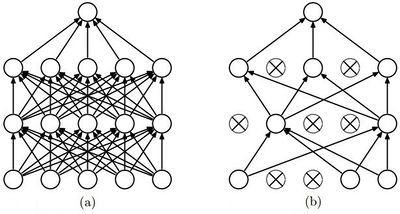  

#### Прореживание (дропаут) 

In [114]:
# Прореживание в среднем слое классификации цифр mnist. При обучении сети будем отключать 50% случайно выбранных узлов
# Для прореживания используется 50%-ное распределение Бернулли (матрица dropout_mask, состоящая из 0 и 1)
np.random.seed(1)
relu = lambda x: (x >= 0) * x    # Возвращает х, если х>0, иначе возвращает 0
relu2deriv = lambda x: x >= 0    # Возвращает 1, если х>0, иначе возвращает 0
alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 300, 100, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1     # weights_0_1.shape (784, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1           # weights_1_2.shape (100, 10)

for j in range(iterations):            # 300
    error, correct_cnt = (0.0, 0)   
    for i in range(len(images)):       # 1000
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2    # Прореживание
        
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    if not j % 10:
        test_error, test_correct_cnt = (0.0, 0)
        for i in range(len(test_images)):

            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))        
        sys.stdout.write("\n" + "I:" + str(j) + \
                         " Test-Err: " + str(test_error / float(len(test_images)))[:5] + \
                         "   Test-Acc: " + str(test_correct_cnt / float(len(test_images))) + \
                         "   Train-Err: " + str(error / float(len(images)))[:5] + \
                         "   Train-Acc: " + str(correct_cnt / float(len(images))))        


I:0 Test-Err: 0.641   Test-Acc: 0.6333   Train-Err: 0.891   Train-Acc: 0.413
I:10 Test-Err: 0.458   Test-Acc: 0.787   Train-Err: 0.472   Train-Acc: 0.764
I:20 Test-Err: 0.415   Test-Acc: 0.8133   Train-Err: 0.430   Train-Acc: 0.809
I:30 Test-Err: 0.421   Test-Acc: 0.8114   Train-Err: 0.415   Train-Acc: 0.811
I:40 Test-Err: 0.419   Test-Acc: 0.8112   Train-Err: 0.413   Train-Acc: 0.827
I:50 Test-Err: 0.409   Test-Acc: 0.8133   Train-Err: 0.392   Train-Acc: 0.836
I:60 Test-Err: 0.412   Test-Acc: 0.8236   Train-Err: 0.402   Train-Acc: 0.836
I:70 Test-Err: 0.412   Test-Acc: 0.8033   Train-Err: 0.383   Train-Acc: 0.857
I:80 Test-Err: 0.410   Test-Acc: 0.8054   Train-Err: 0.386   Train-Acc: 0.854
I:90 Test-Err: 0.411   Test-Acc: 0.8144   Train-Err: 0.376   Train-Acc: 0.868
I:100 Test-Err: 0.411   Test-Acc: 0.7903   Train-Err: 0.369   Train-Acc: 0.864
I:110 Test-Err: 0.411   Test-Acc: 0.8003   Train-Err: 0.371   Train-Acc: 0.868
I:120 Test-Err: 0.402   Test-Acc: 0.8046   Train-Err: 0.353   T

- **сеть без прореживания** на контрольных данных достигла max Acc = 81.14%, а к концу обучения на контроле ее точность упала до 70%.
- **сеть с прореживанием** на контрольных данных достигла max Acc = 82.36%, справилась с переобучением и завершила его с Acc = 81.81%. Прореживание замедляет обучение: рост Train Acc в предыдущем примере без прореживания достиг 100% и остановился. Прореживание отсеивает шум и тормозит обучение.

#### Пакетный градиентный спуск (Batch Gradient Descent) 
Разновидность град. спуска, при котором происходит корректировка весов после просмотра n примеров.   
Этот метод увеличивает скорость обучения и улучшает сходимость.

In [128]:
# Передадим в сеть сразу 100 примеров, усредняя корректирующие значения для весов по всем 100 примерам.
# Точность на контрольных данных изменяется более плавно, чем в предыдущих примерах.
# Это обусловлено усреднением корректирующих воздействий на весовые коэффициенты в процессе обучения.
# Отдельные обучающие примеры вносят очень много шума, в смысле корректирующих значений, которые они генерируют. 
# Усреднение делает процесс более плавным.


# В коде ниже обновление градиентов layer_2_delta, layer_1_delta и весов происходит внутри цикла for k in range(batch_size), 
# что приводит к многократному умножению нейронов на градиенты, а затем обновлению весов для каждой выборки в батче.
# Это может увеличить количество вычислений и сделать процесс обучения менее стабильным.
# iterations = 300, alpha = 0.001, batch_size = 100

np.random.seed(1)

relu = lambda x: (x >= 0) * x    # Возвращает х, если х>0, иначе возвращает 0
relu2deriv = lambda x: x >= 0    # Возвращает 1, если х>0, иначе возвращает 0

batch_size = 100
alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.001, 300, 100, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1     # weights_0_1.shape (784, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1           # weights_1_2.shape (100, 10)

for j in range(iterations):   # 300
    error, correct_cnt = (0.0, 0)    
    for i in range(int(len(images) / batch_size)):  # 10
        batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
        
        layer_0 = images[batch_start:batch_end]     # Пакетный град. спуск
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2                 # Прореживание        
        layer_2 = np.dot(layer_1, weights_1_2)
        error += np.sum((labels[batch_start:batch_end] - layer_2) ** 2)
        
        for k in range(batch_size):   # 100     
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k : batch_start+k+1]))

            layer_2_delta = (labels[batch_start:batch_end] - layer_2) / batch_size
            layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
            layer_1_delta *= dropout_mask

            weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)             
        
    if not j % 10:
        test_error, test_correct_cnt = (0.0, 0)
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
        
        sys.stdout.write("\n" + "I:" + str(j) + \
                         " Test-Err: " + str(test_error / float(len(test_images)))[:5] + \
                         "   Test-Acc: " + str(test_correct_cnt / float(len(test_images))) + \
                         "   Train-Err: " + str(error / float(len(images)))[:5] + \
                         "   Train-Acc: " + str(correct_cnt / float(len(images))))                


I:0 Test-Err: 0.815   Test-Acc: 0.3832   Train-Err: 1.284   Train-Acc: 0.165
I:10 Test-Err: 0.568   Test-Acc: 0.7173   Train-Err: 0.591   Train-Acc: 0.672
I:20 Test-Err: 0.510   Test-Acc: 0.7571   Train-Err: 0.532   Train-Acc: 0.729
I:30 Test-Err: 0.485   Test-Acc: 0.7793   Train-Err: 0.498   Train-Acc: 0.754
I:40 Test-Err: 0.468   Test-Acc: 0.7877   Train-Err: 0.489   Train-Acc: 0.749
I:50 Test-Err: 0.458   Test-Acc: 0.793   Train-Err: 0.468   Train-Acc: 0.775
I:60 Test-Err: 0.452   Test-Acc: 0.7995   Train-Err: 0.452   Train-Acc: 0.799
I:70 Test-Err: 0.446   Test-Acc: 0.803   Train-Err: 0.453   Train-Acc: 0.792
I:80 Test-Err: 0.451   Test-Acc: 0.7968   Train-Err: 0.457   Train-Acc: 0.786
I:90 Test-Err: 0.447   Test-Acc: 0.795   Train-Err: 0.454   Train-Acc: 0.799
I:100 Test-Err: 0.448   Test-Acc: 0.793   Train-Err: 0.447   Train-Acc: 0.796
I:110 Test-Err: 0.441   Test-Acc: 0.7943   Train-Err: 0.426   Train-Acc: 0.816
I:120 Test-Err: 0.442   Test-Acc: 0.7966   Train-Err: 0.431   Trai

In [22]:
# Передадим в сеть сразу 100 примеров, усредняя корректирующие значения для весов по всем 100 примерам.
# Точность на контрольных данных изменяется более плавно, чем в предыдущих примерах.
# Это обусловлено усреднением корректирующих воздействий на весовые коэффициенты в процессе обучения.
# Отдельные обучающие примеры вносят очень много шума, в смысле корректирующих значений, которые они генерируют. 
# Усреднение делает процесс более плавным.


# Веса обновляются после обработки всего батча, что позволяет использовать векторизованные операции и уменьшает количество повторных вычислений.
# iterations = 300, alpha = 0.001, batch_size = 100
import sys, numpy as np
from keras.datasets import mnist
np.random.seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test), 28*28) / 255
test_labels = np.zeros((len(y_test), 10))

for i, l in enumerate(y_test):
    test_labels[i][l] = 1

relu = lambda x: (x >= 0) * x    # Возвращает х, если х>0, иначе возвращает 0
relu2deriv = lambda x: x >= 0    # Возвращает 1, если х>0, иначе возвращает 0

batch_size = 100
alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.001, 300, 100, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1     # weights_0_1.shape (784, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1           # weights_1_2.shape (100, 10)

for j in range(iterations):   # 300
    error, correct_cnt = (0.0, 0)    
    for i in range(int(len(images) / batch_size)):  # 10
        batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
        
        layer_0 = images[batch_start:batch_end]     # Пакетный град. спуск
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2                 # Прореживание
        
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[batch_start:batch_end] - layer_2) ** 2)
        
        for k in range(batch_size):   # 100     
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k : batch_start+k+1]))

        layer_2_delta = (labels[batch_start:batch_end] - layer_2) / batch_size
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)             
        
    if not j % 10:
        test_error, test_correct_cnt = (0.0, 0)
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))        
        sys.stdout.write("\n" + "I:" + str(j) + \
                         " Test-Err: " + str(test_error / float(len(test_images)))[:5] + \
                         "   Test-Acc: " + str(test_correct_cnt / float(len(test_images))) + \
                         "   Train-Err: " + str(error / float(len(images)))[:5] + \
                         "   Train-Acc: " + str(correct_cnt / float(len(images))))                


I:0 Test-Err: 1.513   Test-Acc: 0.0667   Train-Err: 2.080   Train-Acc: 0.084
I:10 Test-Err: 1.107   Test-Acc: 0.118   Train-Err: 1.534   Train-Acc: 0.097
I:20 Test-Err: 1.020   Test-Acc: 0.1621   Train-Err: 1.347   Train-Acc: 0.147
I:30 Test-Err: 0.974   Test-Acc: 0.1973   Train-Err: 1.268   Train-Acc: 0.147
I:40 Test-Err: 0.938   Test-Acc: 0.2319   Train-Err: 1.225   Train-Acc: 0.141
I:50 Test-Err: 0.909   Test-Acc: 0.2609   Train-Err: 1.127   Train-Acc: 0.19
I:60 Test-Err: 0.885   Test-Acc: 0.2943   Train-Err: 1.102   Train-Acc: 0.213
I:70 Test-Err: 0.863   Test-Acc: 0.3233   Train-Err: 1.062   Train-Acc: 0.221
I:80 Test-Err: 0.845   Test-Acc: 0.3509   Train-Err: 1.028   Train-Acc: 0.253
I:90 Test-Err: 0.828   Test-Acc: 0.3755   Train-Err: 0.992   Train-Acc: 0.271
I:100 Test-Err: 0.814   Test-Acc: 0.3953   Train-Err: 0.975   Train-Acc: 0.28
I:110 Test-Err: 0.801   Test-Acc: 0.4166   Train-Err: 0.937   Train-Acc: 0.312
I:120 Test-Err: 0.789   Test-Acc: 0.4347   Train-Err: 0.923   Tra

In [45]:
# Передадим в сеть сразу 100 примеров, усредняя корректирующие значения для весов по всем 100 примерам.
# Точность на контрольных данных изменяется более плавно, чем в предыдущих примерах.
# Это обусловлено усреднением корректирующих воздействий на весовые коэффициенты в процессе обучения.
# Отдельные обучающие примеры вносят очень много шума, в смысле корректирующих значений, которые они генерируют. 
# Усреднение делает процесс более плавным.


# Веса обновляются после обработки всего батча, что позволяет использовать векторизованные операции и уменьшает количество повторных вычислений.
# iterations = 500, alpha = 0.03, batch_size = 50

import sys, numpy as np
from keras.datasets import mnist
np.random.seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test), 28*28) / 255
test_labels = np.zeros((len(y_test), 10))

for i, l in enumerate(y_test):
    test_labels[i][l] = 1

relu = lambda x: (x >= 0) * x    # Возвращает х, если х>0, иначе возвращает 0
relu2deriv = lambda x: x >= 0    # Возвращает 1, если х>0, иначе возвращает 0

batch_size = 50
alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.03, 500, 100, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.2 и вычитании 0.1 значения в матрице переходят в диапазон от -0.1 до 0.1
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1     # weights_0_1.shape (784, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1           # weights_1_2.shape (100, 10)

for j in range(iterations):   
    error, correct_cnt = (0.0, 0)    
    for i in range(int(len(images) / batch_size)):  # 10
        batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
        
        layer_0 = images[batch_start:batch_end]     # Пакетный град. спуск
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2                 # Прореживание       
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[batch_start:batch_end] - layer_2) ** 2)
        
        for k in range(batch_size):   # 100     
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k : batch_start+k+1]))

        # Веса обновляются после обработки всего батча, что позволяет использовать векторизованные операции и уменьшает количество повторных вычислений
        layer_2_delta = (labels[batch_start:batch_end] - layer_2) / batch_size
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)             
        
    if any([not j % 50, j==iterations-1]):
        test_error, test_correct_cnt = (0.0, 0)
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)
            test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))        
        sys.stdout.write("\n" + "I:" + str(j) + \
                         " Test-Err: " + str(test_error / float(len(test_images)))[:5] + \
                         "   Test-Acc: " + str(test_correct_cnt / float(len(test_images))) + \
                         "   Train-Err: " + str(error / float(len(images)))[:5] + \
                         "   Train-Acc: " + str(correct_cnt / float(len(images))))                


I:0 Test-Err: 0.886   Test-Acc: 0.2875   Train-Err: 1.364   Train-Acc: 0.133
I:50 Test-Err: 0.485   Test-Acc: 0.7822   Train-Err: 0.502   Train-Acc: 0.745
I:100 Test-Err: 0.452   Test-Acc: 0.7966   Train-Err: 0.462   Train-Acc: 0.787
I:150 Test-Err: 0.443   Test-Acc: 0.7993   Train-Err: 0.435   Train-Acc: 0.815
I:200 Test-Err: 0.438   Test-Acc: 0.7979   Train-Err: 0.439   Train-Acc: 0.811
I:250 Test-Err: 0.432   Test-Acc: 0.8009   Train-Err: 0.406   Train-Acc: 0.824
I:300 Test-Err: 0.430   Test-Acc: 0.8026   Train-Err: 0.402   Train-Acc: 0.84
I:350 Test-Err: 0.428   Test-Acc: 0.8072   Train-Err: 0.394   Train-Acc: 0.857
I:400 Test-Err: 0.422   Test-Acc: 0.8062   Train-Err: 0.392   Train-Acc: 0.845
I:450 Test-Err: 0.423   Test-Acc: 0.8032   Train-Err: 0.383   Train-Acc: 0.844
I:499 Test-Err: 0.417   Test-Acc: 0.813   Train-Err: 0.380   Train-Acc: 0.848

- Здесь берется среднее зашумленного сигнала (средняя величина изменения веса, полученная по 100 обучающим примерам).    
- Каждый вызов функции np.dot() вычисляет сразу 100 скалярных произведений. Скаляр. произведение пакетами выполняется гораздо быстрее.   
- Размер пакета в Batch Gradient Descent, как правило, выбирают от 8 до 256.

## 2.3 Стандартные функции активации для скрытых слоев и выходного слоя     
Практики реализации нейронных сетей. Функции активации [https://neerc.ifmo.ru/wiki](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8_%D1%80%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9)  

**Ограничения для функции активации:**  
- Функция должна быть непрерывной и бесконечной на всей обл. определения (должна возвращать число для любого входного значения).    
- Хорошие функции активации монотонны и не меняют направление (значение функции должно всегда возрастать или убывать. Чтобы ни для каких двух входных значений не получился одинаковый результат). Технически это требование не яв-ся обязательным, немонотонные функции можно оптимизировать. Но важно помнить, что они могут отображать множество входов в одно и тоже выходное значене.  
- Хорошие функции активации нелинейны, имеют точки перегиба. Чтобы создать эпизодическую корреляцию, нужно позволить нейронам выборочно коррелировать с входными нейронами. Таким образом можно уменьшить влияние сильного отрицательного сигнала от одного входа на корреляцию нейрона с любыми другими входами (принудительно обратив значение нейрона в 0, как это делает функция relu). Этому процессу способствует любая изгибающаяся (нелинейная) ф-ия. Хорошая ф-ия активации не позволяет одному весу нивелировать корреляцию нейрона с другими весами. Это помогает создавать выборочную (эпизодическую) корреляцию. Необходимо, чтобы входной сигнал, попадающий в нейрон с функцией активации, мог увеличивать или уменьшать корреляцию нейрона с др. входными сигналами. 
- Хорошие функции активации (и их производные) должны иметь низкую вычислительную сложность.    

Существует бесконечное кол-во функций, которые подойдут в качестве ф-ии активации, но подавляющее большинство потребностей удовлетворяется следующими функциями      
- Стандартные функции активации для **скрытых слоев**: Relu, Sigmoid, Tanh (наиболее часто используется в скрытых слоях)       
- Стандартные функции активации для **выходного слоя**: Sigmoid, Softmax (наиболее часто используется в многоклассовой классиф-ии)     


**Наиболее часто используемые функции активации:**
- **Relu** (Rectified Linear Unit) - обращает в 0 узлы с отрицательным значением. Один из самых простых способов организовать нелинейность.  
- **Sigmoid** - гладкая монотонная возрастающая нелинейная функция, имеющая форму буквы «S», которая часто применяется для «сглаживания» значений некоторой величины. Плавно сжимает бесконечный диапазон входных значений в диапазон от 0 до 1, что позволяет интерпретировать выход отдельно взятого нейрона как вероятность. В выходном слое часто используется для получения бинароного прогноза (или нескольких бинарных прогнозов. напр.: вероятность победы команды, вероятность позитивного эмоционального состояния игроков). Функция sigmoid моделирует вероятности для каждого выходного узла независимо.    
- **Tanh** (Hyperbolic Tangent - гиперболический тангенс) - сжимает входные значения в диапазон от -1 до 1. Наиболее часто используемая ф-ия активации для скрытых слоев, сохраняет отрицательные значения (может усиливать отрицательную корреляцию) и обеспечивает нелинейность.  
- **Softmax** - многопеременная логистическая функция — обобщение логистической функции для многомерного случая. Прогноз  - выбор одного варианта из нескольких, сумма возвращаемых вероятностей равна 1 (чем более вероятна какая-то одна метка, тем менее вероятны все остальные). Softmax экспоненциально увеличивает каждое входное значение и затем делит на сумму слоя.  
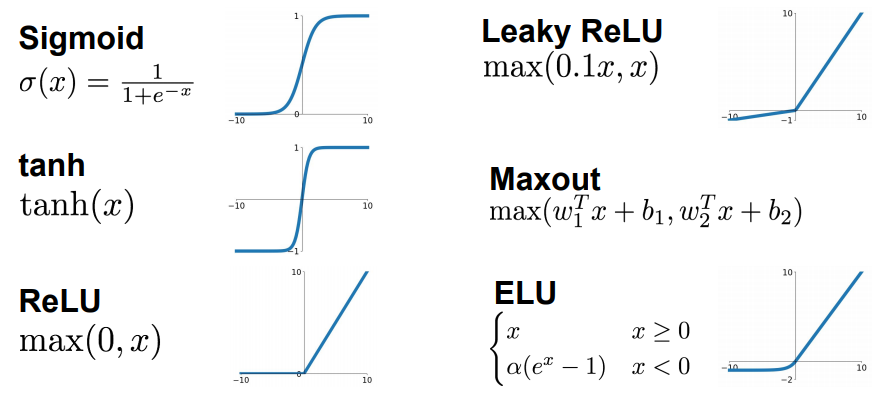  
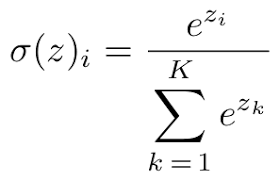

#### Усовершенствование сети MNIST, использование функции активации Tanh в скрытом слое и Softmax в выходном слое   
- Для Tanh было уменьшено стандартное отклонение входящих весов. Веса инициализируются случайными числами (метод np.random.random создает матрицу со случайными значениями от 0 до 1). При использовании функции relu мы умножали матрицу весов на 0.2 и вычитали 0.1. Таким образом значения стартовых весов переходили в диапазон от -0.1 до 0.1 (это отлично работало с функцией relu). Функция активации Tanh работает эффективнее при более узком диапазоне исходных значений весов, поместим их в диапазон от -0.01 до 0.01.  
- Softmax лучше использовать с функцией ошибки перекрестной энтропией.  
- В этой сети использовался пакетный стохастический градиентный спуск, в сеть передавались по 100 примеров, усредняя корректирующие значения для весов по всем 100 примерам. При пакетном град. спуске точность на контрольных данных изменяется более плавно. Это обусловлено усреднением корректирующих воздействий на весовые коэффициенты в процессе обучения. Отдельные обучающие примеры вносят очень много шума, в смысле корректирующих значений, которые они генерируют. Усреднение делает процесс более плавным.  
- В этой сети был увеличен альфа-коэффициент. Сеть достигла точности на проверке в 87% (итерация 270)     
I:270     
Test-Acc: 0.8703     
Train-Acc: 0.951.   

In [26]:
import sys, numpy as np
from keras.datasets import mnist
np.random.seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Train data
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])  # (1000, 728), (1000)
one_hot_labels = np.zeros((len(labels), 10))   # (1000, 10)
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels   # (1000, 10)

# Test data
test_images = x_test.reshape(len(x_test), 28*28) / 255  # (10000, 784)
test_labels = np.zeros((len(y_test), 10))               
for i, l in enumerate(y_test):
    test_labels[i][l] = 1                               # (10000, 10)
    
print(f'SHAPE: \nimages: {images.shape},  labels {labels.shape}')
print(f'test_images: {test_images.shape},  test_labels {test_labels.shape}')

SHAPE: 
images: (1000, 784),  labels (1000, 10)
test_images: (10000, 784),  test_labels (10000, 10)


In [27]:
def tanh(x):                 # Гиперболический тангенс - наиболее удобная функция активации для скрытого слоя
    return np.tanh(x)        # Сжимает входные значения в диапазон от -1 до 1 
def tanh2deriv(output):      # Производная функции tanh
    return 1 - (output**2)
def softmax(x):            # softmax - наиболее удобная функция активации для выходного слоя многоклассовой классификации
    temp = np.exp(x)       # Функция экспоненциально увеличивает каждое входное значение и затем делит на сумму слоя
    result = temp / np.sum(temp, axis = 1, keepdims = True)  # Сумма возвращаемых вероятностей равна 1 
    return result          # Чем более вероятна какая-то одна метка, тем менее вероятны все остальные                            
batch_size = 100
alpha, iterations, hidden_size, pixels_per_image, num_labels = (2, 300, 100, 784, 10)

# Веса инициализируются случайными числами. np.random.random создает матрицу со случайными значениями от 0 до 1. 
# При умножении на 0.02 и вычитании 0.01 значения в матрице переходят в диапазон от -0.01 до 0.01
# Функция активации для скрытого слоя Tanh работает лучше при более узком диапазоне исходных значений весов
weights_0_1 = 0.02 * np.random.random((pixels_per_image, hidden_size)) - 0.01    # shape (784, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1            # shape (100, 10)


for j in range(iterations):   # 300
    correct_cnt =  0    
    for i in range(int(len(images) / batch_size)):  # 10
        batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
        
        layer_0 = images[batch_start:batch_end]                    # Пакетный град. спуск   layer_0.shape (100, 784)
        layer_1 = tanh(np.dot(layer_0, weights_0_1))               # Функция активации в скрытом слое - tanh.  layer_1.shape (100, 100)
        
        dropout_mask = np.random.randint(2, size = layer_1.shape)  # Прореживание (отключение случайных узлов)  dropout_mask.shape (100, 100) 
        layer_1 *= dropout_mask * 2                                # слой layer_1 после прореживания 
        
        layer_2 = softmax(np.dot(layer_1, weights_1_2))            # Функция автивации на выходе - softmax.  layer_2.shape (100, 10) 
        
        for k in range(batch_size):   # 100     
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k : batch_start+k+1]))

        layer_2_delta = (labels[batch_start:batch_end] - layer_2) / (batch_size * layer_2.shape[0])  # shape(100, 10)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)                       # shape(100, 100)
        layer_1_delta *= dropout_mask 

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)  # shape(100, 10)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)  # shape(784, 100)
    test_correct_cnt = 0

    for i in range(len(test_images)):
        layer_0 = test_images[i:i+1]
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
   
    if not j % 10:     
        sys.stdout.write("\n" + "I:" + str(j) +  "   Test-Acc: " + str(test_correct_cnt / float(len(test_images))) + \
                                                 "   Train-Acc: " + str(correct_cnt / float(len(images))))


I:0   Test-Acc: 0.394   Train-Acc: 0.156
I:10   Test-Acc: 0.6867   Train-Acc: 0.723
I:20   Test-Acc: 0.7025   Train-Acc: 0.732
I:30   Test-Acc: 0.734   Train-Acc: 0.763
I:40   Test-Acc: 0.7663   Train-Acc: 0.794
I:50   Test-Acc: 0.7913   Train-Acc: 0.819
I:60   Test-Acc: 0.8102   Train-Acc: 0.849
I:70   Test-Acc: 0.8228   Train-Acc: 0.864
I:80   Test-Acc: 0.831   Train-Acc: 0.867
I:90   Test-Acc: 0.8364   Train-Acc: 0.885
I:100   Test-Acc: 0.8407   Train-Acc: 0.883
I:110   Test-Acc: 0.845   Train-Acc: 0.891
I:120   Test-Acc: 0.8481   Train-Acc: 0.901
I:130   Test-Acc: 0.8505   Train-Acc: 0.901
I:140   Test-Acc: 0.8526   Train-Acc: 0.905
I:150   Test-Acc: 0.8555   Train-Acc: 0.914
I:160   Test-Acc: 0.8577   Train-Acc: 0.925
I:170   Test-Acc: 0.8596   Train-Acc: 0.918
I:180   Test-Acc: 0.8619   Train-Acc: 0.933
I:190   Test-Acc: 0.863   Train-Acc: 0.933
I:200   Test-Acc: 0.8642   Train-Acc: 0.926
I:210   Test-Acc: 0.8653   Train-Acc: 0.931
I:220   Test-Acc: 0.8668   Train-Acc: 0.93
I:23

## 2.4 Введение в сверточные нейронные сети  

### Повторное использование весов в нескольких местах. Сверточный слой

- Самая серьезная проблема нейросетей - переобучение, когда сеть запоминает тренировочные данные, вместо выявления полезной информации, которую можно обобщить на другие похожие данные (такая сеть делает предсказание на основе шума в тренировочном наборе данных, игнорируя основной сигнал).  
- Существуют различные способы борьбы с переобучением: регуляризация, **повторное использование отдельных весов** и др.  
- Склонность сети к переобучению определяется отношением между кол-вом весов и кол-вом точек данных, на основе которых происходит обучение весов.   
- Повторное использование отдельных весов для нескольких целей, когда ожидается, что одна и та же закономерность будет проявляться в нескольких местах, способствует борьбе с переобучением и увеличению точности модели за счет уменьшения отношения количества весов к количеству точек в данных.   
- Как правило, уменьшение кол-ва параметров делает сеть менее выразительной, однако при правильном построении механизма повторного использ-я весов  сеть может остаться такой же выразительной и при этом стать более устойчивой к переобучению. 
- **Свертка (сверточный слой)** - наиболее широко известная и часто применимая структура в нейросетях. При использовании сверточного слоя вместо одного большого слоя, связывающего каждый вход с каждым выходом, в каждой позиции на входе повторно используется множество очень маленьких линейных слоев. Каждый такой мини-слой называется сверточным ядром. Как правило, каждое сверточное ядро имеет около 25 входов и один выход. Обычно сверточные слои имеют довольно много ядер. Каждое ядро плавно сканирует одно и то же изображение и в результате дает матрицу прогноза. Затем матрицы прогноза от всех ядер обобщаются в итоговую матрицу. Именно эта окончательная матрица передается на следующий уровень нейронной сети. Обобщение итоговых матриц от разных ядер в сверточном слое можно осуществлять различными способами: 1) объединение суммированием (сложить соответствующие значения поэлементно), 2) объединение с усреднением (взять поэлементное среднее), 3) объединение с выбором максимального (выбрать максимальные значения из соответствующих элементов - наиболее часто применяемый прием). Каждое ядро в сверточном слое изучает определенную закономерность и потом обнаруживает ее везде, где она присутствует в изображении. Каждое сверточное ядро просматривает множество сегментов данных, из-за чего меняется отношение кол-ва весов к кол-ву точек данных, на которых обучаются эти веса. Выход сверточного слоя является серией двумерных изображений (выход каждого сверточного ядра в каждой позиции входных изображений). Использование сверточного слоя позволяет бороться с переобучением и улучшить способность сети к обобщению.   
- Часто используется несколько сверточных слоев, которые накладываются друг на друга, таким образом каждый следующий сверточный слой интерпретирует результат предыдущего как входнное изображение. Типы слоёв в подобных сетях: свёрточный слой, понижение размерности (Pooling - локальное усреднение, локальный максимум и др.), полносвязный слой (Fully-connected). Pooling нужен для получения инвариантного представления признаков, снижения размерности данных 
- Deep Learning —  это обучение иерархии признаковых представлений. 

In [9]:
import sys, numpy as np
from keras.datasets import mnist
np.random.seed(1)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Train data
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])  # (1000, 728), (1000)
one_hot_labels = np.zeros((len(labels), 10))   # (1000, 10)
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels   # (1000, 10)

# Test data
test_images = x_test.reshape(len(x_test), 28*28) / 255  # (10_000, 784)
test_labels = np.zeros((len(y_test), 10))               
for i, l in enumerate(y_test):
    test_labels[i][l] = 1                               # (10_000, 10)
    
print(f'SHAPE: \nimages: {images.shape},  labels {labels.shape}')              # (1000, 784) (1000, 10)
print(f'test_images: {test_images.shape},  test_labels {test_labels.shape}')   # (10_000, 784) (10_000, 10)

SHAPE: 
images: (1000, 784),  labels (1000, 10)
test_images: (10000, 784),  test_labels (10000, 10)


In [10]:
def tanh(x):                 # Гиперболический тангенс - наиболее удобная функция активации для скрытого слоя
    return np.tanh(x)        # Сжимает входные значения в диапазон от -1 до 1 
def tanh2deriv(output):      # Производная функции tanh
    return 1 - (output**2)
def softmax(x):            # softmax - наиболее удобная функция активации для выходного слоя многоклассовой классификации
    temp = np.exp(x)       # Функция экспоненциально увеличивает каждое входное значение и затем делит на сумму слоя
    result = temp / np.sum(temp, axis = 1, keepdims = True)  # Сумма возвращаемых вероятностей равна 1 
    return result          # Чем более вероятна какая-то одна метка, тем менее вероятны все остальные
                            
batch_size = 128
alpha, iterations, pixels_per_image, num_labels = (2, 300, 784, 10)

input_rows = input_cols = 28      
kernel_rows = kernel_cols = 3    
num_kernels = 16                # Кол-во ядер в сверточном слое

input_rows = input_cols = 28      
kernel_rows = kernel_cols = 3    
num_kernels = 16                # Кол-во ядер в сверточном слое

# Размер сверточного слоя (после свертки) = 10_000
hidden_size = ((input_rows - kernel_rows) * (input_cols - kernel_cols)) * num_kernels  # (28-3) * (28-3) * 16 = 10_000

kernels = 0.02 * np.random.random((kernel_rows * kernel_cols, num_kernels)) - 0.01     # Веса перед сверточным слоем (9, 16)
print(f'kernels shape {kernels.shape}') # (9, 16)

weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1
print(f'weights_1_2 shape {weights_1_2.shape}')   # Веса между сверточным и выходным слоями (10_000, 10)

kernels shape (9, 16)
weights_1_2 shape (10000, 10)


In [11]:
def get_image_section(layer, row_from, row_to, col_from, col_to):        # layer shape (128, 28, 28)
    section = layer[:, row_from:row_to, col_from:col_to]                 # section shape (128, 3, 3)
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)  # shape (128, 1, 3, 3)

for j in range(iterations):  # 300
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)):             # 7
        batch_start, batch_end = ((i * batch_size), ((i + 1) * batch_size))
        layer_0 = images[batch_start:batch_end]                # layer_0.shape -> (128, 784)
        layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)    # layer_0.shape -> (128, 28, 28)

        sects = list()  # Список sects для заполнения подобластями для всех 128 картинок в батче.  len(sects) = 625
        for row_start in range(layer_0.shape[1] - kernel_rows):       # 25 
            for col_start in range(layer_0.shape[2] - kernel_cols):   # 25
                sect = get_image_section(layer_0,    # layer_0.shape -> (128, 28, 28)
                                         row_start,  
                                         row_start + kernel_rows,    
                                         col_start,
                                         col_start + kernel_cols)
                # Список sects длиной 625 (25*25)  подобрастей для всех 128 картинок в батче   len(sects) = 625
                sects.append(sect)  # sects[0].shape(128, 1, 3, 3)

        expanded_input = np.concatenate(sects, axis = 1)              # (128, 625, 3, 3) 
        es = expanded_input.shape 
        flattened_input = expanded_input.reshape(es[0] * es[1], -1)   # (80_000, 9)

        kernel_output = flattened_input.dot(kernels)                  # (80_000, 9) @ (9, 16) = (80_000, 16)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))              # (128, 10_000)
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2                                   # Прореживание в прямом распространении (способ регуляриз. откл. случайных улов)
        layer_2 = softmax(np.dot(layer_1, weights_1_2))               # (128, 10_000) @ (10_000, 10) = (128, 10)

        for k in range(batch_size): # 128
            labelset = labels[batch_start+k : batch_start+k+1]
            _inc = int(np.argmax(layer_2[k:k+1]) == np.argmax(labelset))
            correct_cnt += _inc

        layer_2_delta = (labels[batch_start:batch_end]-layer_2) / (batch_size * layer_2.shape[0])  # (128, 10)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)                     # (128, 10) @ (10, 10_000) = (128, 10_000)
        layer_1_delta *= dropout_mask                                                              # Прореживание в обратном распространении   
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)          # Измение весов weights_1_2 -=   2 * (10_000, 128) @ (128, 10) = (10_000, 10)
        l1d_reshape = layer_1_delta.reshape(kernel_output.shape)     # (80_000, 16)
        k_update = flattened_input.T.dot(l1d_reshape)                # (9, 80_000) @ (80_000, 16) = (9, 16)
        kernels -= alpha * k_update                                  # Изменение весов kernels -=  2 * (9, 16)
    
    test_correct_cnt = 0

    for i in range(len(test_images)):  # 10_000
        layer_0 = test_images[i:i+1]                                    # (1, 784)
        layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)             # (1, 28, 28)
        layer_0.shape

        sects = list()
        for row_start in range(layer_0.shape[1] - kernel_rows):         # 25  
            for col_start in range(layer_0.shape[2] - kernel_cols):     # 25 
                sect = get_image_section(layer_0,                       # (1, 28, 28)
                                         row_start,
                                         row_start + kernel_rows,
                                         col_start,
                                         col_start + kernel_cols)
                # Список sects длиной 625 (25*25)  подобрастей для каждой картинки   len(sects) = 625
                sects.append(sect)   # sects[0].shape(1, 1, 3, 3)

        expanded_input = np.concatenate(sects, axis = 1)               # (1, 625, 3, 3)
        es = expanded_input.shape                                      # (1, 625, 3, 3)
        flattened_input = expanded_input.reshape(es[0] * es[1], -1)    # (625, 9)

        kernel_output = flattened_input.dot(kernels)        # (625, 9) @ (9, 16) = (625, 16)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))    # (1, 10_000)
        layer_2 = np.dot(layer_1, weights_1_2)              # (1, 10_000) @ (10000, 10) = (1, 10)

        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
    if j % 10 == 0:
        sys.stdout.write("\n"+ "I:" + str(j) + " Test-Acc:"+str(test_correct_cnt / float(len(test_images))) + \
                                               " Train-Acc:" + str(correct_cnt / float(len(images))))


I:0 Test-Acc:0.0288 Train-Acc:0.055
I:10 Test-Acc:0.3563 Train-Acc:0.181
I:20 Test-Acc:0.0133 Train-Acc:0.022
I:30 Test-Acc:0.6608 Train-Acc:0.426
I:40 Test-Acc:0.7352 Train-Acc:0.54
I:50 Test-Acc:0.4202 Train-Acc:0.21
I:60 Test-Acc:0.7401 Train-Acc:0.525
I:70 Test-Acc:0.7973 Train-Acc:0.64
I:80 Test-Acc:0.8237 Train-Acc:0.666
I:90 Test-Acc:0.8393 Train-Acc:0.687
I:100 Test-Acc:0.8511 Train-Acc:0.737
I:110 Test-Acc:0.8588 Train-Acc:0.754
I:120 Test-Acc:0.8629 Train-Acc:0.753
I:130 Test-Acc:0.8694 Train-Acc:0.753
I:140 Test-Acc:0.8666 Train-Acc:0.756
I:150 Test-Acc:0.873 Train-Acc:0.785
I:160 Test-Acc:0.8751 Train-Acc:0.774
I:170 Test-Acc:0.8764 Train-Acc:0.79
I:180 Test-Acc:0.8778 Train-Acc:0.794
I:190 Test-Acc:0.8774 Train-Acc:0.787
I:200 Test-Acc:0.8776 Train-Acc:0.792
I:210 Test-Acc:0.8788 Train-Acc:0.804
I:220 Test-Acc:0.8793 Train-Acc:0.799
I:230 Test-Acc:0.8807 Train-Acc:0.8
I:240 Test-Acc:0.8787 Train-Acc:0.809
I:250 Test-Acc:0.8786 Train-Acc:0.808
I:260 Test-Acc:0.8799 Train-A

Замена первого слоя предыдущей сети сверточным слоем увеличила точность предсказания на несколько процентов. 

In [12]:
batch_start = 0
batch_end = 128
print(images.shape)  # (1000, 784)

layer_0 = images[batch_start:batch_end]
print(layer_0.shape)   # (128, 784)

layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)
print(layer_0.shape)  # (128, 28, 28)

(1000, 784)
(128, 784)
(128, 28, 28)


In [13]:
print(layer_0.shape[1] - kernel_rows)
print(layer_0.shape[2] - kernel_rows)
print(layer_0[:, 0:3, 1:4].shape)

25
25
(128, 3, 3)


In [14]:
sects = list()

def get_image_section(layer, row_from, row_to, col_from, col_to):
    section = layer[:, row_from:row_to, col_from:col_to]
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)

for row_start in range(layer_0.shape[1] - kernel_rows):
    for col_start in range(layer_0.shape[2] - kernel_cols):
        sect = get_image_section(layer_0, 
                                 row_start,
                                 row_start + kernel_rows,
                                 col_start,
                                 col_start + kernel_cols)        
        sects.append(sect)

print(len(sects))
print(sects[7].shape)
sects[0]

625
(128, 1, 3, 3)


array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       ...,


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

# 3. Введение в обработку естественного языка (NLP)       
    3.1 Векторное представление слов. Тональный анализ текста 
    3.2 Подстановка пропущенных слов. Словесные аналогии    
    3.3 Bag of words
    3.4 Реккурентные слои

## 3.1 Векторное представление слов. Тональный анализ текста  

В общем случае задачи NLP можно разделить на три большие группы:  
- классификация области текста (определение части речи, эмоциональной окраски, именованной сущности и тд)  
- соотнесение нескольких областей в тексте (выяснение кореферентности, т.е. действительно ли два упоминания объекта реального мира относятся к одному и тому же объекту, которым может быть человек, геогр.объект или др. именованная сущность)  
- восполнение отсутствующей информации, пропущенных слов по контексту

### Классификация обзоров  фильмов с IMDB. Тональный анализ текста (позитивный \ негативный отзыв)
Набор данных с IMDB - коллекция пар "обзор - рейтинг". Обзоры состоят из нескольких предложений, рейтинги - числа от 1 до 5. 

- One-hot-encoding (Метод прямого кодирования). Создание входной матрицы, представляющей словарь обзора фильма. В такой матрице каждая строка (вектор) соответствует какому-либо одному обзору фильма, каждый столбец показывает содержит ли обзор определенное слово. 
- Получение векторного представления обзоров путем сложения векторов.
- Создание нейронной сети для предсказания тональной окраски текста (позитивный \ негативный отзыв).     

In [4]:
f = open('reviews.txt')
raw_reviews = f.readlines()
f.close()

f = open('labels.txt')
raw_labels = f.readlines()
f.close()

print(f'Кол-во raw_reviews: {len(raw_reviews)}')
print(f'Кол-во raw_labels: {len(raw_labels)}\n')
print(raw_reviews[0])   # 25000
print(raw_labels[0])

Кол-во raw_reviews: 25000
Кол-во raw_labels: 25000

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   

positive



In [23]:
open('reviews.txt').readlines()[17]

'this film is mediocre at best . angie harmon is as funny as a bag of hammers . her bitchy demeanor from  law and order  carries over in a failed attempt at comedy . charlie sheen is the only one to come out unscathed in this horrible anti  comedy . the only positive thing to come out of this mess is charlie and denise  s marriage . hopefully that effort produces better results .  \n'

In [24]:
# Предварительная обработка. Создание входной матрицы
tokens = list(map(lambda x: set(x.split(' ')), raw_reviews))   # Создание токенов для всех обзоров  
print(len(tokens))                                             # 25000 

vocab = set()                # Создание множества уникальных слов из всего корпуса отзывов 
for sent in tokens:          # 25000 
    for word in sent:        
        if  len(word) > 0:
            vocab.add(word)
            
vocab = list(vocab)         # Список уникальных слов из всего корпуса отзывов    
print(len(vocab))           # Кол-во уникальных слов 74074

word_to_index = {}
for i, word in enumerate(vocab):
    word_to_index[word] = i
print(len(word_to_index))     # 74074

25000
74074
74074


In [33]:
print(vocab[:5])
print(list(word_to_index.items())[:5])

{'', 'fetched', 'of', 'a', 'as', 'tried', 'financially', 'years', 's', 'age', 'closer', 'schools', 'that', 'other', 'line', 'believe', 'much', 'scramble', 'ran', 'knew', 'saw', 'about', 'expect', 'students', 'think', 'high', 'cartoon', 'pity', 'pomp', 'student', 'inspector', 'insightful', 'in', 'comedy', 'pettiness', 'here', 'who', 'to', 'one', 'adults', 'which', 'classic', 'is', 'profession', 'the', 'some', 'teachers', 'immediately', 'school', 'my', 'repeatedly', 'pathetic', 'time', 'me', 'right', 'situation', 'through', 'all', 'see', 'satire', 'whole', 'your', 'far', 'their', 'down', 'sack', 'remind', 'can', 'i', 'many', 'teaching', 'welcome', 'recalled', 'than', 'such', 'm', 'life', 'and', 't', 'it', 'same', '.', 'at', '\n', 'when', 'bromwell', 'reality', 'programs', 'episode', 'burn', 'lead', 'what', 'survive', 'isn'}
['symbiont', 'paulie', 'hawkes', 'nines', 'eurasians']
[('symbiont', 0), ('paulie', 1), ('hawkes', 2), ('nines', 3), ('eurasians', 4)]


In [36]:
# Входные данные
input_dataset = list()
for sent in tokens:
    sent_indices = list()
    for word in sent:
        try:
            sent_indices.append(word_to_index[word])
        except:
            ''
    input_dataset.append(list(set(sent_indices)))      # input_dataset - список списков. Хранятся уникальные индексы слов для каждого обзора
                                                       # Всего обзоров 25000
print(f'Размер input_dataset {len(input_dataset)}')    # Длина списка input_dataset = 25.000 
print(input_dataset[0])

# Истинный таргет
target_dataset = list()
for label in raw_labels:
    if label == 'positive\n': target_dataset.append(1)
    else: target_dataset.append(0)                       # Список из 0 и 1 (негативный / позитивный отзыв) 

print(f'Размер target_dataset {len(target_dataset)}')    # 25000
print(target_dataset[0])  

Размер input_dataset 25000
[15360, 35331, 43529, 5658, 22558, 52256, 29749, 64571, 19516, 26690, 23115, 25165, 39502, 65104, 28243, 43099, 26715, 20574, 5215, 71267, 40548, 44133, 62055, 13424, 69745, 49266, 49273, 54915, 6281, 5782, 39589, 4774, 14505, 50866, 34996, 40117, 65716, 57532, 9409, 67787, 1235, 48853, 29399, 21216, 70375, 61160, 20213, 4865, 7431, 10504, 9481, 23830, 45850, 11553, 36146, 37684, 65847, 40759, 52537, 62267, 4928, 3910, 70987, 45912, 34144, 38251, 33645, 73072, 10101, 14210, 9100, 59794, 24991, 2469, 5033, 41387, 12720, 68023, 4538, 56764, 60871, 28618, 7628, 47062, 61920, 21985, 14306, 51169, 71658, 40428, 28653, 33789, 17919]
Размер target_dataset 25000
1


In [41]:
np.random.seed(1)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
alpha, iterations, hidden_size = 0.01, 2, 100

weights_0_1 = 0.2 * np.random.random((len(vocab), hidden_size)) - 0.1  # (74074, 100)
weights_1_2 = 0.2 * np.random.random((hidden_size, 1)) - 0.1           # (100, 1)
correct, total = 0, 0

for iteration in range(iterations):  # 2
    for i in range(len(input_dataset) - 1000):                # Обучение на первых 24.000 обзорах
        x, y = input_dataset[i], target_dataset[i]
        layer_1 = sigmoid(np.sum(weights_0_1[x], axis = 0))   # Векторное представление + sigmoid.  layer_1.shape -> (100,)
        layer_2 = sigmoid(np.dot(layer_1, weights_1_2))       # layer_2.shape -> (1,) 
        
        layer_2_delta = layer_2 - y                           # layer_2_delta.shape  -> (1,)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)      # Обратное распространение   layer_1_delta.shape  -> (100,)
        
        weights_0_1[x] -= layer_1_delta * alpha                    # weights_0_1[x].shape -> (input_dataset[i], 100)
        weights_1_2 -= np.outer(layer_1, layer_2_delta) * alpha    # weights_1_2.shape -> (100, 1)
        
        if np.abs(layer_2_delta) < 0.5:
            correct += 1
        total += 1
        if i % 10 == 9:
            progress = str(i / float(len(input_dataset)))
            sys.stdout.write('\rIter: ' + str(iteration) + ' Progress: ' + progress[2:4] + '.' + progress[4:6] \
                                                                             + ' %    Train Acc: ' + str(correct / float(total))[:5] + ' %')           
    print()
    
correct, total = 0, 0
for i in range(len(input_dataset) - 1000, len(input_dataset)):   # Проверка на оставшейся 1000 обзорах фильмов
    x, y = input_dataset[i], target_dataset[i]    
    layer_1 = sigmoid(np.sum(weights_0_1[x], axis = 0))          # Суммирование по столбцам 
    layer_2 = sigmoid(np.dot(layer_1, weights_1_2))
    
    if np.abs(layer_2 - y) < 0.5: correct += 1
    total += 1   
print(f'Test Accuracy: {correct / float(total)}')

Iter: 0 Progress: 95.99 %    Train Acc: 0.835 %
Iter: 1 Progress: 95.99 %    Train Acc: 0.868 %
Test Accuracy: 0.849


- **В процессе обучения скрытый слой ищет полезные способы группировки входных данных**. Он должен способствовать пердсказанию выходной метки. Нейронные сети осуществляют поиск закономерностей в данных, для решения этой задачи они отыскивают полезные способы группировки. Способ группировки должен обнаруживать в данных искомую закономерность. Плохой способ группировки просто запоминает данные, хороший - находит закономерности в данных, полезные с лингвистической точки зрения. К примеру, понимание разницы между "ужасно" и "не ужасно" - очень мощный способ группировки. Но т.к. на вход нейронной сети подается словарь обзора, фраза "отлично, не ужасно" создаст в слое №1 такое же значение, как и "ужасно, не отлично". По этой причине сети едва ли удастся создать скрытый нейрон, понимающий отрицание.    
- **Скрытый слой фактически группирует данные из предыдущего слоя**. На низком уровне каждый нейрон классифицирует точку данных как соответствующую или не соответствующую его группе. На высоком уровне две точки данных (два обзора фильмов) похожи, если принадлежат множеству одних и тех же групп. Два входных значения похожи, если имеют схожие веса, связывающие их с разными скрытыми нейронами (имеют одинаковые меры сходства с каждой группой). Слова, обладающие похожими прогнозными признаками, должны соответствовать похожим группам (сочетаниям скрытых нейронов). Слова, обладающие похожими прогнозными признаками (коррелирующие с похожими метками), будут иметь похожие веса, связывающие их с различными нейронами в скрытом слое. Сеть учится объединять их с аналогичными скрытыми нейронами для правильного прогноза в следующем слое. 
- **Слова, принадлежащие похожим группам и имеющие похожие значения весов, будут иметь похожий смысл**. Нейрон имеет схожий смысл с другими нейронами в том же слое тогда, когда имеет аналогичные значения весов, связывающих его со следующим и/или предыдущим слоем. 

In [49]:
# Каждый элемент строки матрицы weights_0_1 представляет вес, связывающий конкретное слово с конкретным скрытым нейроном
# weights_0_1.shape -> (74074, 100) 74074 уникальных слов во всем корпусе. 100 нейронов в скрытом слое (hidden_size)
# Чтобы найти слова, наиболее похожие на данное слово, нужно сравнить вектор весов каждого слова (строку в матрице weights_0_1) 
# с вектором весов целевого слова. Можно использовать различные метрики оценки расстояния: евклидово расст., манхеттенское и др.
# Воспользуемся евклидовым расстоянием для вычисления наиболее похожих слов
from collections import Counter
import math

def similar(target = 'beautiful'):
    target_index = word_to_index[target]
    scores = Counter()
    for word, index in word_to_index.items():
        raw_diff = weights_0_1[index] - weights_0_1[target_index]
        squared_diff = pow(raw_diff, 2)
        scores[word] = -math.sqrt(sum(squared_diff))
    return scores.most_common(10)

similar_df = pd.concat([pd.DataFrame(similar('beautiful'), columns = ['word_beautiful', 'weight']),  \
                        pd.DataFrame(similar('terrible'),  columns = ['word_terrible', 'weight'])], axis = 1)
display(similar_df)

,word_beautiful,weight,word_terrible,weight
0,beautiful,-0.000000,terrible,-0.000000
1,touching,-0.722914,disappointing,-0.710651
2,captures,-0.725174,worse,-0.727727
3,ride,-0.730577,boring,-0.765641
4,unique,-0.732308,laughable,-0.784139
5,moving,-0.737866,annoying,-0.787132
6,unexpected,-0.738322,avoid,-0.804113
7,superior,-0.738585,horrible,-0.821440
8,sent,-0.741834,wasted,-0.830155
9,magic,-0.746666,dull,-0.842104


Стандартное проявление обобщения корреляции. Нейронная сеть стремится создать похожие представления (значения в слое layer_1) на основе прогнозируемой метки, чтобы научиться в итоге предсказывать правильную метку. Сеть пытается убедить скрытые нейроны быть похожими на метки, которые она должна предсказать. 

## 3.2 Подстановка пропущенных слов. Словесные аналогии

In [161]:
# Загурзка данных
f = open('reviews.txt')
raw_reviews = f.readlines()
f.close()

f = open('labels.txt')
raw_labels = f.readlines()
f.close()

print(f'Кол-во raw_reviews: {len(raw_reviews)}')
print(f'Кол-во raw_labels: {len(raw_labels)}\n')
print(raw_reviews[0])  # 25000
print(raw_labels[0])

Кол-во raw_reviews: 25000
Кол-во raw_labels: 25000

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   

positive



In [162]:
# Создание токенов для всех обзоров и словаря
tokens = list(map(lambda x: (x.split(' ')), raw_reviews)) 
print(len(tokens))     # 25000

wordcnt = Counter()
for sent in tokens:
    for word in sent:
        wordcnt[word] -= 1
print(len(wordcnt))

vocab = list(set(map(lambda x: x[0], wordcnt.most_common())))
print(len(vocab))  # 74075

word_to_index = {}
for i, word in enumerate(vocab):
    word_to_index[word] = i
print(len(word_to_index))  # 74075

25000
74075
74075
74075


In [163]:
concatenated = list()
input_dataset = list()

for sent in tokens:
    sent_indices = list()
    for word in sent:
        try:
            sent_indices.append(word_to_index[word])
            concatenated.append(word_to_index[word])
        except:
            ''
    input_dataset.append(sent_indices) 
    
concatenated = np.array(concatenated)

print(len(input_dataset))      # 25000
print(len(input_dataset[0]))   # 185
print(len(input_dataset[2]))   # 537
print(concatenated.shape)      # (7459318,)

25000
185
537
(7459318,)


In [164]:
# Эта нейронная сеть группирует векторные представления слов по-другому 
# Если в предыдущей нейронной сети слова группировались согласно их степени соответствия положит. или отрицат. оценке, 
# то в этой сети слова группируются согласно вероятности занять место отсутствующего слова в фразе (независимо от эмоц.окраски)

np.random.seed(1)
random.seed(1)

random.shuffle(input_dataset)
alpha, iterations, hidden_size, window, negative = 0.05, 2, 50, 2, 5

weights_0_1 = (np.random.rand(len(vocab), hidden_size) - 0.5) * 0.2   # (74075, 50)
weights_1_2 = np.random.rand(len(vocab), hidden_size) * 0             # (74075, 50)

layer_2_target = np.zeros(negative + 1)  # (6,)   
layer_2_target[0] = 1                    # array([1., 0., 0., 0., 0., 0.])


# Каждый элемент строки матрицы weights_0_1 представляет вес, связывающий крнкретное слово с конкретным скрытым нейроном
# weights_0_1.shape -> (74075, 50) 74075 уникальных слов во всем корпусе. 50 нейронов в скрытом слое (hidden_size)
# Чтобы найти слова, наиболее похожие на данное слово, нужно сравнить вектор весов каждого слова (строку в матрице weights_0_1) 
# с вектором весов целевого слова. Можно использовать различные метрики оценки расстояния: евклидово расст., манхеттенское и др.
# Воспользуемся евклидовым расстоянием для вычисления наиболее похожих слов

def similar(target = 'beautiful'):
    target_index = word_to_index[target]
    scores = Counter()
    for word, index in word_to_index.items():
        raw_diff = weights_0_1[index] - weights_0_1[target_index]
        squared_diff = pow(raw_diff, 2)
        scores[word] = -math.sqrt(sum(squared_diff))
    return scores.most_common(10)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


for rev_i, review in enumerate(input_dataset * iterations):
    for target_i in range(len(review)):
        # Прогнозировать только случайное подмножество, т.к. прогнозирование всего словаря обходится слишком дорого 
        target_samples = [review[target_i]]  + list(concatenated[(np.random.rand(negative) * len(concatenated)).astype('int').tolist()])  # 6
        
        left_context = review[max(0, target_i - window) : target_i]                # len = 2
        right_context = review[target_i + 1 : min(len(review), target_i + window)] # len = 1
        
        layer_1 = np.mean(weights_0_1[left_context + right_context], axis = 0)     # layer_1.shape (50,)   weights_0_1.shape (3, 50)
        layer_2 = sigmoid(layer_1.dot(weights_1_2[target_samples].T))              # layer_2.shape (6,)    weights_1_2.T.shape (50, 6)
          
        layer_2_delta = layer_2 - layer_2_target                                   # layer_2_delta.shape (6,)
        layer_1_delta = layer_2_delta.dot(weights_1_2[target_samples])             # layer_1_delta.shape (50,)
        
        weights_0_1[left_context + right_context] -= layer_1_delta * alpha             # weights_0_1.shape (3, 50)    alpha=0.05
        weights_1_2[target_samples] -= np.outer(layer_2_delta, layer_1) * alpha        # weights_1_2.shape (6, 50) 
        
    if not rev_i % 250:
        sys.stdout.write('\rProgress: ' + str(rev_i / float(len(input_dataset) * iterations)) + '  ' +str(similar('terrible')))
    sys.stdout.write( '\rProgress: ' + str(rev_i / float(len(input_dataset) * iterations)))
    
print(*similar('terrible'), sep = '\n')

Progress: 0.99998[('terrible', -0.0), ('horrible', -3.01470702929644), ('brilliant', -3.1163507096017073), ('phenomenal', -3.547617974930231), ('pathetic', -3.643771738779651), ('superb', -3.6726008137969983), ('masterful', -3.7619220581896213), ('marvelous', -3.858171697214831), ('wonderful', -4.022879515072364), ('terrific', -4.028999553344012)])]85)]])]]9155)]]('terrible', -0.0)
('horrible', -2.982308609399237)
('brilliant', -3.3757128311674403)
('phenomenal', -3.6594524629772343)
('pathetic', -3.664501000295991)
('masterful', -3.8852706491980675)
('superb', -3.9381634354559676)
('marvelous', -3.962001341719181)
('bad', -3.983581065366258)
('mediocre', -4.145792492381435)


Эта нейронная сеть обучалась на одном и том же наборе данных и имеет похожую архитектуру, что и предыдущая сеть (три слоя, перекрестная энтропия, функция активации sigmoid), однако мы повлияли на смысловую нагрузку весов в процессе обучения, изменяя ожидаемый результат на выходе. Мы переориентировали сеть на другой результат, выбирая исходные и целевые значения. Несмотря на сходство архитектуры и наборов данных, сети существенно отличаются функцией ошибки, что вызвало группировку слов по-другому. Две нейронные сети могут иметь идентичные начальные веса, обучаться на одном и том же наборе данных, но выявлять совершенно разные закономерности из-за выбора разных ф-й потерь.   

In [165]:
len(input_dataset)

25000

In [166]:
for rev_i, review in enumerate(input_dataset[:2] * iterations):
    print(rev_i, len(review))

0 477
1 195
2 477
3 195


In [167]:
for rev_i, review in enumerate(input_dataset[:2] * iterations):
    print(rev_i, review)

0 [1, 1, 17249, 32319, 1, 3917, 5228, 24933, 15382, 57928, 16704, 60858, 40558, 1, 71120, 60858, 52777, 56236, 68080, 5875, 1, 33660, 16261, 60858, 1600, 50857, 19528, 21120, 9494, 65159, 19588, 33660, 60814, 16006, 9494, 16878, 5228, 72291, 32675, 20389, 65008, 4547, 32883, 1, 61031, 62037, 19528, 24933, 3917, 16742, 34158, 5228, 20935, 34183, 1, 24385, 19528, 12402, 3917, 39496, 25381, 40535, 39496, 19528, 58732, 9494, 62292, 34158, 19528, 58958, 50857, 18395, 65159, 10664, 19195, 34158, 60814, 24896, 1, 21996, 67815, 50857, 56236, 19528, 30701, 9494, 60584, 47383, 1, 1, 5228, 43015, 9263, 1, 1, 36308, 9494, 60814, 24896, 1, 21996, 65917, 1, 33660, 60814, 39025, 1, 65159, 62157, 7641, 67862, 60814, 16006, 5228, 28255, 50857, 1, 73988, 1, 1, 1, 73988, 1, 1, 68767, 39496, 34158, 52771, 37178, 7641, 6301, 14655, 1, 58401, 40040, 4784, 13253, 71791, 19528, 66341, 50857, 17125, 71385, 14883, 73891, 32363, 3742, 19528, 62292, 14554, 1, 24385, 55989, 37968, 19528, 52981, 741, 9494, 53496, 1

### Словесные аналогии (король - мужчина = королева)

- Задача подстановки отсутствующего слова создает векторные представления, обладающие особенностью, которая называется словестной аналогией, позволяющей выполнять простые алгебраические операции над векторами слов.   
- (король - мужчина = королева) Когда во фразе появляется слово "король", определенным образом изменяется вероятность появления других слов в этой фразе: увеличивается вер-ть появления слов муж. рода и слов, имеющих отношение к королевской власти. Из-за того, что слова оказывают подобное влияние на вер-ть результата, они оказываются включенными в похожие комбинации групп. Слово "король" описывается мужским и королевским измерениями в скрытом слое, а "королева" - жен-м и королевским имерениями. Любое линейное сжатие подобных взаимосвязанных статистик будет давать аналогичные результаты.  

In [168]:
print(list(word_to_index.items())[:10])

[('symbiont', 0), ('', 1), ('paulie', 2), ('hawkes', 3), ('nines', 4), ('eurasians', 5), ('tiags', 6), ('mcphillips', 7), ('leer', 8), ('philippians', 9)]


In [169]:
def analogy(positive=['terrible', 'good'], negative=['bad']):   
    norms = np.sum(weights_0_1 * weights_0_1, axis=1)              # norms.shape (74075,)   weights_0_1.shape (74075, 50)
    norms.resize(norms.shape[0], 1)                                # norms.shape (74075, 1)
    
    normed_weights = weights_0_1 * norms                           # normed_weights.shape (74075, 50)
    
    query_vect = np.zeros(len(weights_0_1[0]))                     # query_vect.shape (50,)
    for word in positive:
        query_vect += normed_weights[word_to_index[word]]          # query_vect.shape  (50,)
    for word in negative:
        query_vect -= normed_weights[word_to_index[word]]
    
    scores = Counter()
    for word, index in word_to_index.items():
        raw_difference = weights_0_1[index] - query_vect           # raw_difference.shape (50,)
        squared_difference = raw_difference * raw_difference       # squared_difference.shape  (50,)
        scores[word] = -math.sqrt(sum(squared_difference))        
    return (scores, scores.most_common(10))

In [170]:
scores, most_common = analogy(['terrible','good'], ['bad'])
most_common

[('good', -217.2806937622228),
 ('superb', -217.62331952262335),
 ('decent', -217.88849187625465),
 ('terrific', -217.88888862183038),
 ('fine', -217.99229343764935),
 ('worth', -218.14935578898113),
 ('nice', -218.29436549000542),
 ('brilliant', -218.3220248044966),
 ('terrible', -218.50407810909297),
 ('great', -218.53079016402066)]

In [171]:
scores['excelent']

-222.1312823002386

In [175]:
print(sorted(scores.items(), key = lambda x: x[1])[:15])

[('weren', -226.4206118849829), ('hadn', -226.13249072812062), ('haven', -226.12980263382372), ('hasn', -225.96635982306304), ('aren', -225.9570690351162), ('wasn', -225.82498233792262), ('shouldn', -225.75534370213126), ('ain', -225.73762380014452), ('wouldn', -225.43118836324481), ('couldn', -225.10720634992464), ('than', -225.08702876953726), ('anti', -224.98009374057867), ('isn', -224.9793266100275), ('wondered', -224.85163377615444), ('knew', -224.8012112283082)]


In [179]:
scores2, most_common2 =  analogy(['elizabeth','he'],['she'])

In [181]:
most_common2

[('he', -185.44761511192718),
 ('christopher', -186.49479695193995),
 ('john', -186.96606756119252),
 ('peter', -187.01108830402958),
 ('william', -187.0677875191357),
 ('de', -187.10367988602536),
 ('david', -187.1170910801646),
 ('simon', -187.14453359941848),
 ('jason', -187.1788061725357),
 ('been', -187.18042630444285)]

In [182]:
print('weights_0_1', weights_0_1.shape)

norms = np.sum(weights_0_1 * weights_0_1, axis = 1)
print('norms', norms.shape)
norms.resize(norms.shape[0], 1)
print('norms_resized', norms.shape)
display(norms)
print()

normed_weights = weights_0_1 * norms
print(normed_weights.shape)

weights_0_1 (74075, 50)
norms (74075,)
norms_resized (74075, 1)


array([[ 0.31563693],
       [13.46407928],
       [10.96073887],
       ...,
       [ 0.94622334],
       [ 2.22312144],
       [ 1.01624746]])


(74075, 50)


In [183]:
print(list(word_to_index.items())[:9])

[('symbiont', 0), ('', 1), ('paulie', 2), ('hawkes', 3), ('nines', 4), ('eurasians', 5), ('tiags', 6), ('mcphillips', 7), ('leer', 8)]


In [184]:
print(word_to_index['terrible'])
display(normed_weights[word_to_index['terrible']])

17418


array([ 15.62972801,  54.77146751,  26.61984278,   2.07439577,
        12.92466668,  45.96534127,  -5.74576084, -16.24620472,
        -7.09956403, -52.90998951, -25.43081083,  15.02008783,
        28.99177294,  21.50541504,  37.84174475, -12.39995699,
        -0.78462145,   3.44205518, -10.78640508,  -8.73045792,
        -8.83606898, -17.88018568,  34.47078349,  -5.14645308,
        16.32160394,  -0.9869464 , -16.09464419,  -7.65868742,
        -0.97051331, -33.48951238,   5.19186064,   4.39970912,
       -43.91497288,  -1.99312289,   5.95035573,  -4.27518847,
        -5.65526763,  -0.88328511,  31.82141538,  25.33282822,
        -5.69090747,  11.18081962, -18.30333747,  16.0211976 ,
        -1.17960963,  11.54428783,  -7.83611996,  28.21150541,
        -9.31478208,  27.09004595])

In [186]:
query_vect  = np.zeros(len(weights_0_1[0]))
print(query_vect.shape)

positive=['terrible', 'good'] 
negative=['bad']
for word in positive:
    query_vect += normed_weights[word_to_index[word]]          # query_vect.shape  (50,)
for word in negative:
    query_vect -= normed_weights[word_to_index[word]]
    
sc = Counter()
for word, index in word_to_index.items():
    raw_difference = weights_0_1[index] - query_vect
    squared_difference = raw_difference * raw_difference
    sc[word] = -math.sqrt(sum(squared_difference))
sc.most_common(10)

(50,)


[('good', -217.2806937622228),
 ('superb', -217.62331952262335),
 ('decent', -217.88849187625465),
 ('terrific', -217.88888862183038),
 ('fine', -217.99229343764935),
 ('worth', -218.14935578898113),
 ('nice', -218.29436549000542),
 ('brilliant', -218.3220248044966),
 ('terrible', -218.50407810909297),
 ('great', -218.53079016402066)]

## 3.3 Bag of words

#### Перейдем от векторных представлений, передающих слысл единственного слова, к векторным представлениям, передающим смысл фраз и предложений переменной длины 

In [189]:
def pretty_print_review_and_label(i):
   print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('reviews.txt','r') 
reviews = list(map(lambda x:x[:-1], g.readlines()))
g.close()

g = open('labels.txt','r') 
labels = list(map(lambda x:x[:-1].upper(), g.readlines()))
g.close()

print(len(reviews), len(labels), sep = '\n')

25000
25000


In [196]:
display(reviews[0])
display(labels[0])

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

'POSITIVE'

In [195]:
f = open('reviews.txt')
raw_reviews = f.readlines()
f.close()

f = open('labels.txt')
raw_labels = f.readlines()
f.close()

print(len(raw_reviews), len(raw_labels), sep = '\n')

25000
25000


In [376]:
display(raw_reviews[0])
display(raw_labels[0])

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \n'

'positive\n'

In [198]:
tokens = list(map(lambda x: set(x.split(" ")), raw_reviews))  

vocab = set()
for sent in tokens:
    for word in sent:
        if (len(word) > 0):
            vocab.add(word)
vocab = list(vocab)     # Список всех уникальных слов всего корпуса данных (всех обзоров фильмов)

word2index = {}         
for i, word in enumerate(vocab):
    word2index[word]=i

input_dataset = list()
for sent in tokens:
    sent_indices = list()
    for word in sent:
        try:
            sent_indices.append(word2index[word])
        except:
            ""
    input_dataset.append(list(set(sent_indices)))

target_dataset = list()
for label in raw_labels:
    if label == 'positive\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

In [212]:
print(len(tokens))
print(tokens[0])
print()

print(len(list(word2index.items())))
print(list(word2index.items())[:5])
print()

print(len(input_dataset))
print(input_dataset[:2])
print(len(target_dataset))
print(target_dataset[:2])

25000
{'', 'fetched', 'of', 'a', 'as', 'tried', 'financially', 'years', 's', 'age', 'closer', 'schools', 'that', 'other', 'line', 'believe', 'much', 'scramble', 'ran', 'knew', 'saw', 'about', 'expect', 'students', 'think', 'high', 'cartoon', 'pity', 'pomp', 'student', 'inspector', 'insightful', 'in', 'comedy', 'pettiness', 'here', 'who', 'to', 'one', 'adults', 'which', 'classic', 'is', 'profession', 'the', 'some', 'teachers', 'immediately', 'school', 'my', 'repeatedly', 'pathetic', 'time', 'me', 'right', 'situation', 'through', 'all', 'see', 'satire', 'whole', 'your', 'far', 'their', 'down', 'sack', 'remind', 'can', 'i', 'many', 'teaching', 'welcome', 'recalled', 'than', 'such', 'm', 'life', 'and', 't', 'it', 'same', '.', 'at', '\n', 'when', 'bromwell', 'reality', 'programs', 'episode', 'burn', 'lead', 'what', 'survive', 'isn'}

74074
[('symbiont', 0), ('paulie', 1), ('hawkes', 2), ('nines', 3), ('eurasians', 4)]

25000
[[15360, 35331, 43529, 5658, 22558, 52256, 29749, 64571, 19516, 26

In [213]:
# Запрос со словами "boring" и "awfull" вернул три отрицат. отзыва на фильмы
# В этих векторах содержится интересная стат. информация, объединяющая положит. и отрицат. отзывы в разные группы

# Нормализация векторных представлений слов (матрица normed_weights)
norms = np.sum(weights_0_1 * weights_0_1, axis = 1)   # norms.shape -> (74075,)
norms.resize(norms.shape[0], 1)                       # norms.shape -> (74075, 1)
normed_weights = weights_0_1 * norms                  # normed_weights.shape -> (74075, 50)

In [216]:
# Преобразование каждого обзора фильма в векторное представление при помощи усреднения (матрица reviews_to_vectors)
def make_sent_vect(words):
    indices = list(map(lambda x: word2index[x], filter(lambda x: x in word2index, words)))
    return np.mean(normed_weights[indices], axis = 0)   # (50,)

reviews_to_vectors = list()
for review in tokens:                                   # Лексемизированные обзоры
    reviews_to_vectors.append(make_sent_vect(review))
reviews_to_vectors = np.array(reviews_to_vectors)       # reviews_to_vectors.shape -> (25000, 50)      

In [264]:
print(reviews_to_vectors.shape)  # (25000, 50)
print(reviews_to_vectors[0].shape)

(25000, 50)
(50,)


In [259]:
def most_similar_reviews(review):
    v = make_sent_vect(review)
    scores = Counter()
    for i, val in enumerate(reviews_to_vectors.dot(v)):
        scores[i] = val
        
    most_similar = list()                            
    for indx, score in scores.most_common(3):
        most_similar.append(raw_reviews[indx][:100])
    return most_similar
                
print(*most_similar_reviews(['boring', 'awful']), sep = '\n' )

if you see this turkey listed in your tv guide  avoid it like the plague                  br    br  
this is  without doubt  one of the worst films i  ve ever seen . . .  br    br   the plot is so full
why did i waste my time with this movie  there was not a single funny joke or line throughout . the 


In [260]:
np.mean(normed_weights[list(map(lambda x: word_to_index[x], list(filter(lambda x: x in word_to_index, tokens[0]))))], axis = 0).shape

(50,)

In [261]:
np.mean(normed_weights[input_dataset[0]], axis = 0).shape

(50,)

**Positive reviews**

the king of masks is a beautifully told story that pits the familial gender preference towards males against human preference for 


<Axes: >

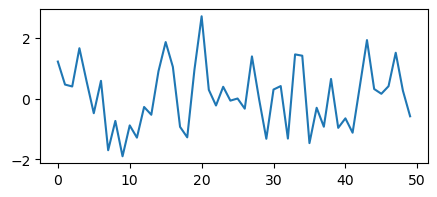

In [322]:
print(reviews[142][:130])
pd.Series(reviews_to_vectors[142]).plot(kind = 'line', figsize = (5, 2))

this film is an hour or so of good entertainment and has some genuinely funny moments . i loved the character of matt  and also ti


<Axes: >

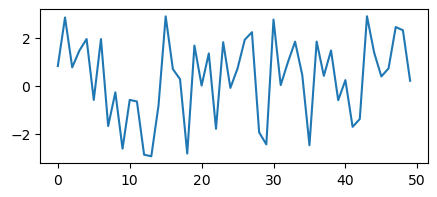

In [352]:
print(reviews[838][:130])
pd.Series(reviews_to_vectors[838]).plot(kind = 'line', figsize = (5, 2))

an utterly beautiful film  one of a handful of i saw when young that entranced me then and still do  in thief  s case the impressi


<Axes: >

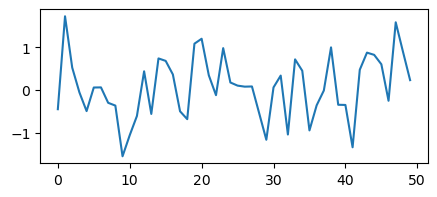

In [353]:
print(reviews[914][:130])
pd.Series(reviews_to_vectors[914]).plot(kind = 'line', figsize = (5, 2))

ah  i loved this movie . i think it had it all . it made me laugh out loud over a dozen of times . yes  i am a girl  so i  m writing this from a girl  s perspective . i think it  s a shame it only scored  .  in rating . too many guys voting  it was far above other romantic comedies . just because i  m female i don  t enjoy all chic flicks  on the contrary i prefer other genres . romantic comedies 


<Axes: >

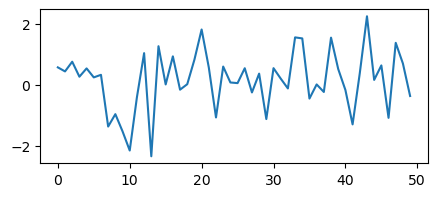

In [371]:
print(reviews[360][:400])
pd.Series(reviews_to_vectors[360]).plot(kind = 'line', figsize = (5, 2))

popular radio storyteller gabriel no one  robin williams  scraggy and speaking in hushed  hypnotic t


<Axes: >

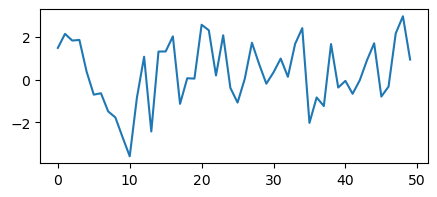

In [373]:
print(reviews[34][:100])
pd.Series(reviews_to_vectors[34]).plot(kind = 'line', figsize = (5, 2))

**Negative reviews**

this show made me feel physically sick  and totally detached from british society as a whole . it was programmes such as this and 


<Axes: >

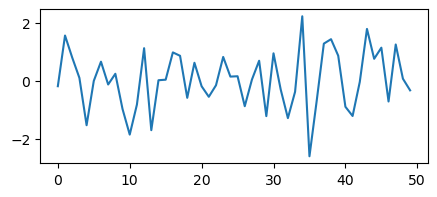

In [323]:
# negative reviews
print(reviews[283][:130])
pd.Series(reviews_to_vectors[283]).plot(kind = 'line', figsize = (5, 2))

ouch  what a painfully boring sci  fi movie  and that  s especially saddening because the opening   minutes were so action  packed


<Axes: >

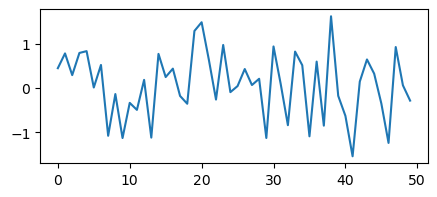

In [330]:
print(reviews[5885][:130])
pd.Series(reviews_to_vectors[5885]).plot(kind = 'line', figsize = (5, 2))

i saw this piece of garbage on amc last night  and wonder how it could be considered in any way an american movie classic . it was awful in every way 


<Axes: >

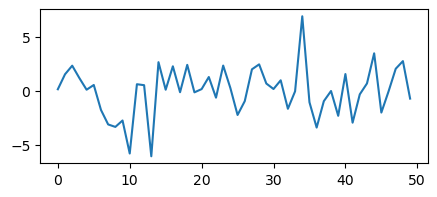

In [332]:
print(reviews[24985][:150])
pd.Series(reviews_to_vectors[24985]).plot(kind = 'line', figsize = (5, 2))

absolutely awful movie . utter waste of time .  br    br   background music is so loud that you cannot understand speech . well if you really listen c


<Axes: >

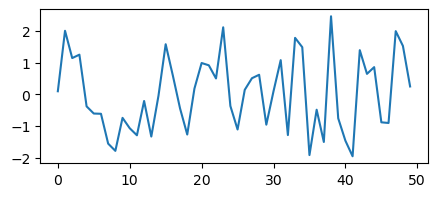

In [340]:
print(reviews[79][:150])
pd.Series(reviews_to_vectors[79]).plot(kind = 'line', figsize = (5, 2))

thoughtless  ignorant  ill  conceived  career  killing  where is the talented angela jones now    deeply unfunny garbage . it  s no wonder reb braddoc


<Axes: >

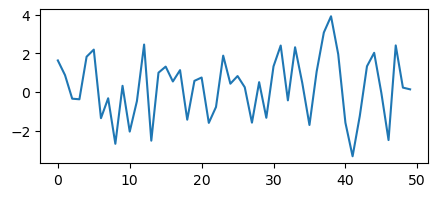

In [349]:
print(reviews[1419][:150])
pd.Series(reviews_to_vectors[1419]).plot(kind = 'line', figsize = (5, 2))

- В результате усреднения векторов слов в предложении получается вектор, отражающий усредненные характеристики отдельных слов. Если в предложении присутствует много положительных слов, итоговый вектор будет иметь положительные черты. Шум от нейтральных слов, как правило, компенсируется.
- Однако этот подход склонен сглаживать обобщённую кривую - при достаточно большом кол-ве слов в результате усреднения их кривых может получиться близкая к прямой линия. Это основной недостаток данного подхода - при попытке сохранить информ-ю из последовательности произвольной длины в векторе фиксированной длины вектор предложения (как среднее по множеству слов) м.б. усреднен (если его длины окажется недостаточно для сохранения большого объема инф-ии) до линии близкой к прямой (т.е. до вектора со значениями близкими к 0). Если попытаться сохранить в одном векторе слишком много слов, главная информация м.б. потеряна.
- Основная проблема в модели "мешок слов" заключается в том, что при усреднении векторных представлений слов их порядок следования не сохраняется и не учитывается.

## 3.4 Реккурентные слои 

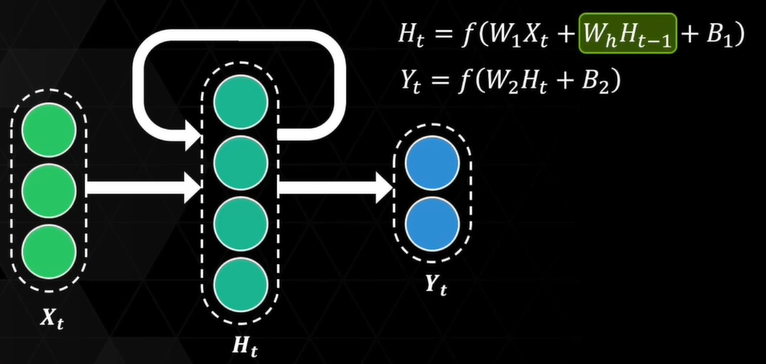

- Благодаря переходной матрице сеть учится внедрять в векторное представление больше информации, чем простую сумму векторов слов (как в предыдущих примерах bag of words). Позволив матрицам (первоначально единичным np.eye) изменяться, мы даем нейронной сети возможность обучиться созданию векторных предсказаний, которые меняются при изменении порядка следования слов. Изменение единичных матриц происходит не произвольно. Сеть обучается учитывать порядок слов так, чтобы максимально точно предсказывать следующее слово.
- Мы также потребовали, чтобы переходная матрица (которая изначально была единичной) была одной и той же на каждом этапе матричного перемножения с вектором слов. Например, для предложения "Red Sox defeat" с прогнозируемым словом - "Yankees", матрица, используемая на этапе перехода "Red"  -> "Sox", будет повторно использована на этапе "Sox" -> "defeat". Всё, чему сеть обучится при анализе первого перехода, будет повторно использовано в следующих переходах, благодаря чему она будет изучать только полезную для прогнозирования логику.

In [263]:
# Загрузка данных
f = open('qa1_single-supporting-fact_train.txt', 'r')
raw = f.readlines()
f.close()

tokens = list()
for line in raw[0:1000]:
    # tokens.append(line.lower().replace("\n","").split(" ")[1:])
    changed_line = [re.sub(r'\t\d*', '', word).strip() for word in line.lower().replace("\n", "").split(" ")[1:]]
    tokens.append(changed_line)
print(len(tokens))
print(tokens[0:3])

1000
[['mary', 'moved', 'to', 'the', 'bathroom.'], ['john', 'went', 'to', 'the', 'hallway.'], ['where', 'is', 'mary?', 'bathroom']]


In [264]:
print(len(tokens))
display(tokens[:5])

1000


[['mary', 'moved', 'to', 'the', 'bathroom.'],
 ['john', 'went', 'to', 'the', 'hallway.'],
 ['where', 'is', 'mary?', 'bathroom'],
 ['daniel', 'went', 'back', 'to', 'the', 'hallway.'],
 ['sandra', 'moved', 'to', 'the', 'garden.']]

In [265]:
print(len(raw))
raw[:2]

3000


['1 Mary moved to the bathroom.\n', '2 John went to the hallway.\n']

In [266]:
# vocab - список всех уникальных слов лексического корпуса
vocab = set()
for sent in tokens:
    for word in sent:
        vocab.add(word)
vocab = list(vocab)

# word2index - дикт слово:индекс
word2index = {}
for i, word in enumerate(vocab):
    word2index[word]=i

# Функция возвращает список индексов слов данного предложения
def words2indices(sentence):
    idx = list()
    for word in sentence:
        idx.append(word2index[word])
    return idx
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [267]:
print(len(vocab))
print(vocab[:9])
print(list(word2index.items())[:5])

29
['office.', 'daniel?', 'kitchen.', 'john?', 'bathroom.', 'went', 'bedroom.', 'bathroom', 'mary?']
[('office.', 0), ('daniel?', 1), ('kitchen.', 2), ('john?', 3), ('bathroom.', 4)]


In [268]:
np.random.seed(1)
embed_size = 10                                                 # Размер векторного представления
embed = (np.random.rand(len(vocab), embed_size) - 0.5) * 0.1    # Матрица векторных представлений слов  shape (29, 10)
recurrent = np.eye(embed_size)    # Реккурентная матрица (первоначально единичная)  shape (10, 10)
start = np.zeros(embed_size)      # Векторное представление для пустого предложения  shape (10,)
# Весовая матрица. Выходные веса для прогнозирования векторного представления предложения  shape (10, 29)
decoder = (np.random.rand(embed_size, len(vocab)) - 0.5) * 0.1   
one_hot = np.eye(len(vocab))      # Матрица поиска выходных весов для функции потерь shape (29, 29)

In [269]:
# Функция для прямого распространения
def predict(sent):    
    layers = list()    # Список со всеми слоями
    layer = {}
    layer['hidden'] = start
    layers.append(layer)

    loss = 0

    preds = list()   # Новая форма организации прямого распространения
    for target_i in range(len(sent)):
        layer = {}
        
        layer['pred'] = softmax(layers[-1]['hidden'].dot(decoder))   
        loss += -np.log(layer['pred'][sent[target_i]])

        layer['hidden'] = layers[-1]['hidden'].dot(recurrent) + embed[sent[target_i]]  # Генерация нового скрытого состояния
        layers.append(layer)
    return layers, loss

In [270]:
# Обратное распространение 
for iter in range(70000):
    alpha = 0.001
    sent = words2indices(tokens[iter%len(tokens)][1:])
    layers, loss = predict(sent) 

    for layer_idx in reversed(range(len(layers))):  # Обратное распространение
        layer = layers[layer_idx]
        target = sent[layer_idx-1]

        if layer_idx > 0: 
            layer['output_delta'] = layer['pred'] - one_hot[target]
            new_hidden_delta = layer['output_delta'].dot(decoder.transpose())

            # Если это последний слой - не добавлять последующий, т.к. его не существует
            if layer_idx == len(layers)-1:
                layer['hidden_delta'] = new_hidden_delta
            else:
                layer['hidden_delta'] = new_hidden_delta + layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())
        else: # Если это первый слой
            layer['hidden_delta'] = layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())

In [271]:
# Изменение весовых матриц и векторов
for iter in range(70000):
    alpha = 0.001
    sent = words2indices(tokens[iter%len(tokens)][1:])

    layers, loss = predict(sent) 

    for layer_idx in reversed(range(len(layers))):  # Обратное распространение
        layer = layers[layer_idx]
        target = sent[layer_idx-1]

        if layer_idx > 0:
            layer['output_delta'] = layer['pred'] - one_hot[target]
            new_hidden_delta = layer['output_delta'].dot(decoder.transpose())

            # Если это последний слой - не добавлять последующий, т.к. его не существует
            if layer_idx == len(layers)-1:
                layer['hidden_delta'] = new_hidden_delta
            else:
                layer['hidden_delta'] = new_hidden_delta + layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())
        else:
            layer['hidden_delta'] = layers[layer_idx+1]['hidden_delta'].dot(recurrent.transpose())

    start -= layers[0]['hidden_delta'] * alpha / float(len(sent)) # Обновление весов
    for layer_idx,layer in enumerate(layers[1:]):
        
        decoder -= np.outer(layers[layer_idx]['hidden'], layer['output_delta']) * alpha / float(len(sent))
        
        embed_idx = sent[layer_idx]
        embed[embed_idx] -= layers[layer_idx]['hidden_delta'] * alpha / float(len(sent))
        recurrent -= np.outer(layers[layer_idx]['hidden'], layer['hidden_delta']) * alpha / float(len(sent))
        
    if iter % 10000 == 0:
        print("Perplexity:" + str(np.exp(loss/len(sent))))

Perplexity:29.102814128637675
Perplexity:14.573799921478644
Perplexity:5.156294887295689
Perplexity:3.9354089212077192
Perplexity:3.4646080304854263
Perplexity:3.100064373144515
Perplexity:3.3728787347823057


In [292]:
print(len(tokens[-1]))
tokens[-1]

5


['sandra', 'went', 'to', 'the', 'garden.']

In [293]:
print(len(layers))
layers

5


[{'hidden': array([ 0.80190296, -0.34240609, -0.71988982,  1.80325143,  1.134657  ,
          0.94698285, -0.84405972, -0.63234847, -0.8922592 , -0.06493814]),
  'hidden_delta': array([ 1.89505592, -2.53208089,  3.2150835 , -1.26921124, -0.73406147,
         -0.43308585, -1.75818326,  0.20908068,  1.37206304,  0.643958  ])},
 {'pred': array([0.00044919, 0.00520861, 0.00042079, 0.0051744 , 0.00052938,
         0.19471141, 0.00043794, 0.00663423, 0.00495581, 0.00685569,
         0.00665765, 0.3747203 , 0.00482093, 0.00444803, 0.10931239,
         0.0010544 , 0.00611263, 0.00641395, 0.005127  , 0.0044177 ,
         0.10777973, 0.01491337, 0.00472809, 0.10314893, 0.0079801 ,
         0.00046366, 0.00726221, 0.00046849, 0.00479298]),
  'hidden': array([-1.18101626,  1.84490799, -3.03873529,  1.28308105, -2.12605332,
          2.64703567, -5.65280323,  0.98755077,  2.00016036,  1.22887325]),
  'output_delta': array([ 4.49193936e-04,  5.20860981e-03,  4.20787925e-04,  5.17440141e-03,
        

In [311]:
print(layers[0]['hidden'].shape)
print(layers[1]['hidden'].shape)
print(layers[1]['hidden_delta'].shape)
print()
print(one_hot.shape)
print(one_hot[target].shape)
print(layers[1]['pred'].shape)
print(layers[1]['output_delta'].shape)

(10,)
(10,)
(10,)

(29, 29)
(29,)
(29,)
(29,)


In [272]:
sent_index = 4
l,_ = predict(words2indices(tokens[sent_index]))
print(tokens[sent_index])

for i, each_layer in enumerate(l[1:-1]):
    input = tokens[sent_index][i]
    true = tokens[sent_index][i+1]
    pred = vocab[each_layer['pred'].argmax()]
    print("Prev Input:" + input + (' ' * (12 - len(input))) + "True:" + true + (" " * (15 - len(true))) + "Pred:" + pred)

['sandra', 'moved', 'to', 'the', 'garden.']
Prev Input:sandra      True:moved          Pred:is
Prev Input:moved       True:to             Pred:to
Prev Input:to          True:the            Pred:the
Prev Input:the         True:garden.        Pred:bedroom


# 4. Введение в автоматическую оптимизацию: создание фреймворка глубокого обучения    
    4.1 Введение в автоматическое вычисление градиента (autograd). Сложение в обратном распространении       
    4.2 Добавление поддержки слоев разных типов (нелинейные слои, слой с векторным представлением, слой с перекрестной энтропией, реккурентный слой)    

## 4.1 Введение в автоматическое вычисление градиента (autograd). Сложение в обратном распространении

In [38]:
# Эта версия Tensor поддерживает только однократное обратное распространение в переменную
class Tensor (object):
    # Базовая реализация автоматического дифференцирования для операции сложения тензоров
    def __init__(self, data, creators=None, creation_op = None):
        self.data = np.array(data)
        self.creation_op = creation_op
        self.creators = creators
        self.grad = None    
    def backward(self, grad):
        self.grad = grad        
        if self.creation_op == "add":
            self.creators[0].backward(grad)
            self.creators[1].backward(grad)
    def __add__(self, other):
        return Tensor(self.data + other.data,  creators=[self, other], creation_op="add")    
    def __repr__(self):
        return str(self.data.__repr__())    
    def __str__(self):
        return str(self.data.__str__())
    
x = Tensor([1,2,3,4,5])
y = Tensor([2,2,2,2,2])
z = x + y
print('z', z)

z.backward(Tensor(np.array([1,1,1,1,1])))
print(z.grad == x.grad == y.grad) 
print()
print(z.grad)
print(z.creators)
print(z.creation_op)

z [3 4 5 6 7]
True

[1 1 1 1 1]
[array([1, 2, 3, 4, 5]), array([2, 2, 2, 2, 2])]
add


In [31]:
a = Tensor([1,2,3,4,5])
b = Tensor([2,2,2,2,2])
c = Tensor([5,4,3,2,1])
d = Tensor([-1,-2,-3,-4,-5])
e = a + b
f = c + d
g = e + f
g.backward(Tensor(np.array([1,1,1,1,1])))

print(a.grad)  # Градиент был успешно передан от g через e к a во время обратного распространения

[1 1 1 1 1]


В настоящее время код неправильно вычисляет градиенты для обратного распространения в переменную, которая используется несколько раз т.е. является родителем нескольких потомков

In [27]:
# Этот код неправильно вычисляет градиенты для backprop в переменную, которая используется несколько раз т.е. является родителем нескольких потомков
a = Tensor([1,2,3,4,5])
b = Tensor([2,2,2,2,2])
c = Tensor([5,4,3,2,1])

d = a + b
e = b + c  # b участвует в сложении дважды, т.е. ее градиент должен быть суммой двух производных: [2, 2, 2, 2]
f = d + e
f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))
print(b.grad)
print(f.grad)
print(d.grad)

[False False False False False]
[1 1 1 1 1]
[1 1 1 1 1]
[1 1 1 1 1]


В процессе создания переменной f переменная b используется дважды. То есть ее градиент должен быть суммой двух производных: [2, 2, 2, 2]. Но данная реализация Tensor просто перезаписывает каждую производную предыдущей переменной. Изменим способ записи градиентов:

In [39]:
# Изменим способ записи градиентов

class Tensor (object):
    # Базовая реализация автоматического дифференцирования для тензоров
    def __init__(self, data,         # Данные тензора, которые преобразуются в массив NumPy.
                 autograd=False,     # Флаг, указывающий, нужно ли отслеживать градиенты для этого тензора
                 creators=None,      # creators и creation_op используются для отслеживания, как был создан тензор (через сложение)
                 creation_op=None,
                 id=None):           # Уникальный идентификатор тензора (Если не указан, генерируется случайно)       
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if id is None: self.id = np.random.randint(0, 100000)  # Если id не указан - сгенерировать 
        else: self.id = id  
            
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}          # Счетчик, подсчитывающий кол-во градиентов, полученных от каждого потомка в процессе обратного распространения
        
        if creators is not None:
            for c in creators:      # Скорректировать число потомков данного тензера
                if self.id not in c.children:  c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        # Проверяет, получил ли тензор все градиенты от потомков 
        for id, cnt in self.children.items():
            if cnt != 0: return False
        return True        
        
    def backward(self, grad=None, grad_origin=None):
        # Основной метод для обратного распространения. Если autograd включен, метод вычисляет градиенты
        if self.autograd:
            if grad is None: grad = FloatTensor(np.ones_like(self.data))  # Если гладиент не был указан - сгенерировать заполненный единицами
                
            # Отслеживает, сколько раз градиент от каждого потомка был учтен, и предотвращает повторное распространение градиента
            if grad_origin is not None:  # Проверяет, что градиенты передаются только один раз
                if self.children[grad_origin.id] == 0:  raise Exception("Cannot backprop more than once")   
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad    
            else: self.grad += grad   # Накопление градиентов от нескольких потомков
                
            # Гарантирует, что градиенты, используемые для обратного распространения, не отслеживают свои собственные градиенты               
            assert grad.autograd == False     # Для защиты от ошибок, связанных с передачей неправильных градиентов в метод backward
            
            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):
                # Фактическое начало обратного распространения
                if self.creation_op == "add":    
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
    def __add__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data + other.data, autograd=True, creators=[self, other], creation_op="add")
        return Tensor(self.data + other.data)
        
    def __repr__(self):
        return str(self.data.__repr__())    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)
d = a + b
e = b + c
f = d + e

# Вызывается метод backward для тензора f с начальным градиентом. Метод вычисляет градиенты для всех тензоров, которые участвовали в создании f
f.backward(Tensor(np.array([1,1,1,1,1])))  
print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


Логика обратного распростр. вызывает метод backward дважды, по одному разу для каждой родительской переменной, участвовавшей в сложении. Т.е. логика по умолчанию обратного распространения заключается в распространении градиента через каждую переменную в вычислительном графе. Но иногда обратное распространение требуется пропустить, например, если переменная исключена из вычисления градиента (self.autograd == False). Эта проверка выполняется в методе backward.

In [51]:
class Tensor (object):
    # Добавление поддержки отрицания
    def __init__(self, data,           # Данные тензора, которые преобразуются в массив NumPy
                 autograd=False,       # Флаг, указывающий, нужно ли отслеживать градиенты для этого тензора
                 creators=None,        # creators и creation_op используются для отслеживания, как был создан тензор (например, через сложение)
                 creation_op=None,
                 id=None):             # Уникальный идентификатор тензора (Если не указан, генерируется случайно) 
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if id is None: self.id = np.random.randint(0, 100000)
        else: self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}  # Счетчик, подсчитывающий кол-во градиентов, полученных от каждого потомка в процессе обратного распространения
        
        if creators is not None:
            for c in creators:    # Скорректировать число потомков данного тензера
                if self.id not in c.children: c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        # Проверяет, получил ли тензор все градиенты от потомков 
        for id, cnt in self.children.items():
            if cnt != 0: return False
        return True        
        
    def backward(self, grad=None, grad_origin=None):
        # Основной метод для обратного распространения. Если autograd включен, метод вычисляет градиенты
        if self.autograd:            
            if grad is None: grad = FloatTensor(np.ones_like(self.data))  # Если градиент не был пеердан - сгенерировать   

            # Отслеживает, сколько раз градиент от каждого потомка был учтен, и предотвращает повторное распространение градиента
            if grad_origin is not None:   # Проверяет, что градиенты передаются только один раз
                if self.children[grad_origin.id] == 0:  raise Exception("Cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad    
            else: self.grad += grad   # Накопление градиентов от нескольких потомков
                
            # Гарантирует, что градиенты, используемые для обратного распространения, не отслеживают свои собственные градиенты           
            assert grad.autograd == False  # Для защиты от ошибок, связанных с передачей неправильных градиентов в метод backward

            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):
                # Фактическое начало обратного распространения
                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)                   
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
    def __add__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data + other.data, autograd=True, creators=[self, other], creation_op="add")
        return Tensor(self.data + other.data)
    def __neg__(self):
        if self.autograd:
            return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)     
    def __repr__(self):
        return str(self.data.__repr__())    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)
d = a + (-b)
e = (-b) + c
f = d + e

# Когда в прямом распространении используется -b вместо b, градиенты в обратном распространении также должны менять знак 
f.backward(Tensor(np.array([1,1,1,1,1])))
display(b.grad.data == np.array([-2,-2,-2,-2,-2]))    
display(b.grad.data)
display(-b.grad.data)
print()
display(d.grad == f.grad == e.grad == d.grad)
display(f.grad.data)

array([ True,  True,  True,  True,  True])

array([-2, -2, -2, -2, -2])

array([2, 2, 2, 2, 2])

True

array([1, 1, 1, 1, 1])

**Добавление поддержки других операций: вычитание, умножение, расширение, транспонирование и матричное умножение**

In [2]:
class Tensor (object):
    # Добавление поддержки других операций: вычитание, умножение, расширение, транспонирование и матричное умножение
    def __init__(self, data,           # Данные тензора, которые преобразуются в массив NumPy
                 autograd=False,       # Флаг, указывающий, нужно ли отслеживать градиенты для этого тензора
                 creators=None,        # creators и creation_op используются для отслеживания, как был создан тензор (через сложение)
                 creation_op=None,
                 id=None):             # Уникальный идентификатор тензора (Если не указан, генерируется случайно)
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if id is None: self.id = np.random.randint(0, 100000)
        else: self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}  # Счетчик, подсчитывающий кол-во градиентов, полученных от каждого потомка в процессе обратного распространения
        
        if creators is not None:
            for c in creators:    # Скорректировать число потомков данного тензера
                if self.id not in c.children: c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        # Проверяет, получил ли тензор все градиенты от потомков 
        for id, cnt in self.children.items():
            if cnt != 0: return False
        return True 
        
    def backward(self, grad=None, grad_origin=None):
        # Основной метод для обратного распространения. Если autograd включен, метод вычисляет градиенты
        if self.autograd:
           # Если градиент не указан, он инициализируется единичным тензором, который имеет ту же форму, что и данные тензора loss
            if grad is None: grad = Tensor(np.ones_like(self.data))

            # Отслеживает, сколько раз градиент от каждого потомка был учтен, и предотвращает повторное распространение градиента
            if grad_origin is not None:                 # Проверяет, что градиенты передаются только один раз
                if self.children[grad_origin.id] == 0: raise Exception("Cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1 

            if self.grad is None: self.grad = grad   
            else: self.grad += grad   # Накопление градиентов от нескольких потомков
                
            # Гарантирует, что градиенты, используемые для обратного распространения, не отслеживают свои собственные градиенты
            assert grad.autograd == False    # Для защиты от ошибок, связанных с передачей неправильных градиентов в метод backward
            
            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):
            # Фактическое начало обратного распространения
                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if self.creation_op == "mm":
                    c0 = self.creators[0]  # Обычно слой активации
                    c1 = self.creators[1]  # Обчно весовая матрица
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim, self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
    def __add__(self, other):
        if self.autograd and other.autograd: return Tensor(self.data + other.data, autograd=True, creators=[self, other], creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if self.autograd: return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if self.autograd and other.autograd: return Tensor(self.data - other.data, autograd=True, creators=[self, other], creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if self.autograd and other.autograd: return Tensor(self.data * other.data, autograd=True, creators=[self, other], creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if self.autograd: return Tensor(self.data.sum(dim), autograd=True, creators=[self], creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim, copies):  # Используется для обратного распространения операции .sum(). Она копирует данные по измерению
        trans_cmd = list(range(0, len(self.data.shape)))
        trans_cmd.insert(dim, len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)       
        if self.autograd: return Tensor(new_data, autograd=True, creators=[self], creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if self.autograd: return Tensor(self.data.transpose(), autograd=True, creators=[self], creation_op="transpose")        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if self.autograd: return Tensor(self.data.dot(x.data), autograd=True, creators=[self, x], creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def __repr__(self):
        return str(self.data.__repr__())   
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)
d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))
print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


**Сравним две записи сети**

In [3]:
np.random.seed(0)
data = np.array([[0,0], [0,1], [1,0], [1,1]])
target = np.array([[0], [1], [0], [1]])

weights_0_1 = np.random.rand(2,3)
weights_1_2 = np.random.rand(3,1)

for i in range(10):    
    layer_1 = data.dot(weights_0_1)          # Прямое распространение, предсказание
    layer_2 = layer_1.dot(weights_1_2)

    diff = (layer_2 - target)                # Сравнение
    sqdiff = (diff * diff)
    loss = sqdiff.sum(0)                     # mse

    layer_1_grad = diff.dot(weights_1_2.transpose())   # Обратное распространение, изменение весов
    weight_1_2_update = layer_1.transpose().dot(diff)
    weight_0_1_update = data.transpose().dot(layer_1_grad)
    
    weights_1_2 -= weight_1_2_update * 0.1
    weights_0_1 -= weight_0_1_update * 0.1
    print(loss[0])

5.066439994622395
0.4959907791902342
0.4180671892167177
0.35298133007809646
0.2972549636567377
0.2492326038163328
0.20785392075862477
0.17231260916265176
0.14193744536652986
0.11613979792168384


In [4]:
# Базовая реализация нейронной сети с автоматическим дифференцированием для обратного распространения ошибки
# Вся необходимая инфа сохраняется в динамическом вычислительном графе. Нет необходимости вручную определять логику обратного распространения 
# Обратное распространение реализовано в методе .backward(). Форма фреймворка наиболее удобна и снижает вероятность ошибок в коде обр. распростр.

np.random.seed(0)
data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

w = list()
w.append(Tensor(np.random.rand(2, 3), autograd=True))   # hidden_layer.shape (4, 3)
w.append(Tensor(np.random.rand(3, 1), autograd=True))   # output_layer.shape (4, 1)


for i in range(10):
    pred = data.mm(w[0]).mm(w[1])                    # Прямое распространение (матричное перемножение, метод mm), предсказание. shape (4, 1)
    loss = ((pred - target)*(pred - target)).sum(0)  # Сравнение, вычисление ошибки loss как сумма квадратов разностей между pred и target
    
    # Обратное распространение. Градиент распространяется назад через операции sum, mul, sub, и mm, обновляя градиенты всех создателей
    loss.backward(Tensor(np.ones_like(loss.data)))   # Градиент инициализируется единичным тензором array([1.])   shape (1,)
    
    for w_ in w:            # Обновление весов w[0] и w[1] 
        w_.data -= w_.grad.data * 0.1
        w_.grad.data *= 0   # Обнуление градиентов 
    print(loss)

[0.58128304]
[0.48988149]
[0.41375111]
[0.34489412]
[0.28210124]
[0.2254484]
[0.17538853]
[0.1324231]
[0.09682769]
[0.06849361]


In [5]:
a = ((pred - target)*(pred - target))
display(a)
print(a.sum(0))
np.ones_like(a.sum(0).data)

array([[0.        ],
       [0.02953983],
       [0.03837645],
       [0.00057732]])

[0.06849361]


array([1.])

In [7]:
class SGD(object):
    # Добавление автоматической оптимизации (оптимизатор стохастического градиентного спуска)   
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters  # Список с весовыми матрицами 
        self.alpha = alpha            # темп обучения learning rate    
    def zero(self):
        for p in self.parameters: 
            p.grad.data *= 0        
    def step(self, zero=True):        
        for p in self.parameters:            
            p.data -= p.grad.data * self.alpha    # Изменение весовых матриц        
            if zero: p.grad.data *= 0             # Обнуление градиента

In [6]:
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

w = list()
w.append(Tensor(np.random.rand(2,3), autograd=True))
w.append(Tensor(np.random.rand(3,1), autograd=True))

optim = SGD(parameters=w, alpha=0.1)

for i in range(10):
    pred = data.mm(w[0]).mm(w[1])                     # Прямое распространение, предсказание    
    loss = ((pred - target)*(pred - target)).sum(0)   # Вычисление ошибки    
    loss.backward(Tensor(np.ones_like(loss.data)))    # Обратное распространение    
    optim.step()                                      # Изменение весов, обнуление градиента, класс SGD  (Автоматическая оптимизация)            
    print(loss)

[0.58128304]
[0.48988149]
[0.41375111]
[0.34489412]
[0.28210124]
[0.2254484]
[0.17538853]
[0.1324231]
[0.09682769]
[0.06849361]


## 4.2 Добавление поддержки слоев разных типов (нелинейные слои, слой с векторным представлением, слой с перекрестной энтропией, реккурентный слой)     

Вероятно, наиболее распространенная абстракция в большинстве фреймворков — абстракция слоя. Это коллекция процедур, часто используемых в прямом распространении, упакованных в простой программный интерфейс с методом .forward() для их использования

In [8]:
class Layer(object):  
    # Простой линейный слой
    def __init__(self):
        self.parameters = list()        
    def get_parameters(self):
        return self.parameters


class Linear(Layer):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)                    # Весовая матрица
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)    # Матрица смещений весов
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0, len(input.data))

In [9]:
# Наибольшей популярностью в практике глубокого обучения пользуются последовательные слои, которые осуществляют прямое распространение 
# через список слоев, когда выход одного слоя передается на вход следующего
class Sequential(Layer):    
    def __init__(self, layers=list()):
        super().__init__()        
        self.layers = layers    
    def add(self, layer):
        self.layers.append(layer)        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input   
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

np.random.seed(0)
data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Linear(3,1)])
optim = SGD(parameters=model.get_parameters(), alpha=0.05)

for i in range(10):   
    pred = model.forward(data)    
    loss = ((pred - target)*(pred - target)).sum(0)    
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[2.33428272]
[0.06743796]
[0.0521849]
[0.04079507]
[0.03184365]
[0.02479336]
[0.01925443]
[0.01491699]
[0.01153118]
[0.00889602]


In [10]:
# Можно также определить слои, выход которых является функцией от входов. Например, слои с функцией потерь MSE
class MSELoss(Layer):    
    # Слои с функцией потерь MSE
    def __init__(self):
        super().__init__()    
    def forward(self, pred, target):
        return ((pred - target) * (pred - target)).sum(0)
    
np.random.seed(0)
data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Linear(3,1)])
criterion = MSELoss()
optim = SGD(parameters=model.get_parameters(), alpha=0.05)

for i in range(10):    
    pred = model.forward(data)  
    loss = criterion.forward(pred, target)   
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[2.33428272]
[0.06743796]
[0.0521849]
[0.04079507]
[0.03184365]
[0.02479336]
[0.01925443]
[0.01491699]
[0.01153118]
[0.00889602]


**Добавим в Tensor нелинейные функции активации и определим несколько новых типов слоев**

In [11]:
class Tensor(object):    
    def __init__(self, data, autograd=False, creators=None, creation_op=None, id=None):       
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if id is None: self.id = np.random.randint(0, 100000)
        else: self.id = id
          
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if creators is not None:
            for c in creators:
                if self.id not in c.children: c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id, cnt in self.children.items():
            if cnt != 0:
                return False
        return True 
        
    def backward(self, grad=None, grad_origin=None):
        if self.autograd:
            if grad is None: grad = Tensor(np.ones_like(self.data))

            if grad_origin is not None:
                if self.children[grad_origin.id] == 0: raise Exception("cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad
            else: self.grad += grad
            
            assert grad.autograd == False

            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):

                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if self.creation_op == "mm":
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim, self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
                if self.creation_op == "sigmoid":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if self.creation_op == "tanh":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                    
    def __add__(self, other):
        if (self.autograd and other.autograd): return Tensor(self.data + other.data, autograd=True, creators=[self,other], creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if self.autograd: return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if (self.autograd and other.autograd): return Tensor(self.data - other.data, autograd=True, creators=[self,other], creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if (self.autograd and other.autograd): return Tensor(self.data * other.data, autograd=True, creators=[self,other], creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if self.autograd: return Tensor(self.data.sum(dim), autograd=True, creators=[self], creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)        
        if self.autograd: return Tensor(new_data, autograd=True, creators=[self], creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if self.autograd: return Tensor(self.data.transpose(), autograd=True, creators=[self], creation_op="transpose")    
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if self.autograd:
            return Tensor(self.data.dot(x.data), autograd=True, creators=[self,x], creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if self.autograd: return Tensor(1 / (1 + np.exp(-self.data)), autograd=True, creators=[self], creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))
    def tanh(self):
        if self.autograd: return Tensor(np.tanh(self.data), autograd=True, creators=[self], creation_op="tanh")
        return Tensor(np.tanh(self.data))
        
    def __repr__(self):
        return str(self.data.__repr__())   
    def __str__(self):
        return str(self.data.__str__())  


class Tanh(Layer):
    def __init__(self):
        super().__init__()    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()   
    def forward(self, input):
        return input.sigmoid()

In [12]:
np.random.seed(0)
data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Tanh(), Linear(3,1), Sigmoid()])
criterion = MSELoss()
optim = SGD(parameters=model.get_parameters(), alpha=1)

for i in range(10):
    pred = model.forward(data)    
    loss = criterion.forward(pred, target)
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[1.06372865]
[0.75148144]
[0.57384259]
[0.39574294]
[0.2482279]
[0.15515294]
[0.10423398]
[0.07571169]
[0.05837623]
[0.04700013]


**Слой с векторным представлением, поддержка эмбеддингов**

In [13]:
class Embedding(Layer):
    def __init__(self, vocab_size, dim):
        super().__init__()       
        self.vocab_size = vocab_size
        self.dim = dim     
        self.weight = (np.random.rand(vocab_size, dim) - 0.5) / dim

In [14]:
# Добавим поддержку индексирование в autograd. Необходимо гарантировать на этапе обратного распространения размещение градиентов в тех же строках, 
# полученных в результате индексации на этапе прямого распространения. Для этого нужно сохранить исходные индексы, чтобы на этапе обратного распростр.
# мы могли поместить каждый градиент в нужное место, воспользовавшись циклом for

class Tensor (object):    
    def __init__(self,data, autograd=False, creators=None, creation_op=None, id=None):   
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if id is None: self.id = np.random.randint(0,100000)
        else: self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if creators is not None:
            for c in creators:
                if(self.id not in c.children): c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id, cnt in self.children.items():
            if cnt != 0: return False
        return True 
        
    def backward(self, grad=None, grad_origin=None):
        if self.autograd: 
            
            if grad is None: grad = Tensor(np.ones_like(self.data))
                
            if grad_origin is not None:
                if self.children[grad_origin.id] == 0: raise Exception("cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad
            else: self.grad += grad
            
            assert grad.autograd == False

            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):

                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if self.creation_op == "mm":
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim, self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
                if self.creation_op == "sigmoid":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if self.creation_op == "tanh":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "index_select":
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
    def __add__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data + other.data, autograd=True, creators=[self,other], creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if self.autograd:
            return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data, autograd=True, creators=[self,other], creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data, autograd=True, creators=[self,other], creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if self.autograd:
            return Tensor(self.data.sum(dim), autograd=True, creators=[self], creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if self.autograd: return Tensor(new_data, autograd=True, creators=[self], creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if self.autograd: return Tensor(self.data.transpose(), autograd=True, creators=[self], creation_op="transpose")      
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if self.autograd: return Tensor(self.data.dot(x.data), autograd=True, creators=[self,x], creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if self.autograd: return Tensor(1 / (1 + np.exp(-self.data)), autograd=True, creators=[self], creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if self.autograd: return Tensor(np.tanh(self.data), autograd=True, creators=[self], creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):
        if self.autograd:
            new = Tensor(self.data[indices.data], autograd=True, creators=[self], creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def __repr__(self):
        return str(self.data.__repr__())   
    def __str__(self):
        return str(self.data.__str__())  


class Tanh(Layer):
    def __init__(self):
        super().__init__()   
    def forward(self, input):
        return input.tanh()
        
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()  
    def forward(self, input):
        return input.sigmoid()

In [15]:
# После обхода всех индексов и добавления их в правильные строки в новой матрице градиентов она передается обратно в self.creators[0]
# Каждая строка в grad правильно обновляется (здесь добавляется вектор из единиц) в соответствии с тем, сколько раз использовался каждый индекс
x = Tensor(np.eye(5), autograd=True)
x.index_select(Tensor([[1,2,3], [2,3,4]])).backward()
print(x.grad)

[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]]


In [16]:
x.index_select(Tensor([[1,2,3], [2,3,4]]))

array([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]])

In [18]:
class Embedding(Layer):   
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)

In [19]:
# Эта нейронная сеть выявила корреляцию между входными индексами 1 и 2 и прогнозами 0 и 1
np.random.seed(0)

data = Tensor(np.array([1,2,1,2]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

embed = Embedding(5, 3)
model = Sequential([embed, Tanh(), Linear(3,1), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.5)

for i in range(10):
    pred = model.forward(data)
    loss = criterion.forward(pred, target)
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[0.98874126]
[0.6658868]
[0.45639889]
[0.31608168]
[0.2260925]
[0.16877423]
[0.13120515]
[0.10555487]
[0.08731868]
[0.07387834]


**Добавление кросс-энтропии**    
Вычисление softmax и потерь производится в одном классе.

In [28]:
class Tensor (object):   
    def __init__(self,data, autograd=False, creators=None, creation_op=None, id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        
        if(id is None): self.id = np.random.randint(0,100000)
        else: self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if creators is not None:
            for c in creators:
                if(self.id not in c.children): c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id, cnt in self.children.items():
            if cnt != 0:
                return False
        return True 
        
    def backward(self, grad=None, grad_origin=None):
        if self.autograd:
 
            if grad is None: grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0): raise Exception("cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad
            else: self.grad += grad
            
            assert grad.autograd == False

            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):
                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if self.creation_op == "mm":
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim, self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
                if self.creation_op == "sigmoid":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if self.creation_op == "tanh":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "index_select":
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if self.creation_op == "cross_entropy":
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data + other.data, autograd=True, creators=[self,other], creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if self.autograd:
            return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data - other.data, autograd=True, creators=[self,other], creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data * other.data, autograd=True, creators=[self,other], creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if self.autograd:
            return Tensor(self.data.sum(dim), autograd=True, creators=[self], creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim, copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)        
        if self.autograd: return Tensor(new_data, autograd=True, creators=[self], creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if self.autograd:
            return Tensor(self.data.transpose(), autograd=True, creators=[self], creation_op="transpose")      
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if self.autograd:
            return Tensor(self.data.dot(x.data), autograd=True, creators=[self,x], creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if self.autograd:
            return Tensor(1 / (1 + np.exp(-self.data)), autograd=True, creators=[self], creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if self.autograd:
            return Tensor(np.tanh(self.data), autograd=True, creators=[self], creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):
        if self.autograd:
            new = Tensor(self.data[indices.data], autograd=True, creators=[self], creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,  axis=len(self.data.shape)-1,  keepdims=True)      
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()  
        if self.autograd:
            out = Tensor(loss, autograd=True, creators=[self], creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out
        return Tensor(loss)
           
    def __repr__(self):
        return str(self.data.__repr__())  
    def __str__(self):
        return str(self.data.__str__())  


class Tanh(Layer):
    def __init__(self):
        super().__init__()    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()   
    def forward(self, input):
        return input.sigmoid()

class CrossEntropyLoss(object):    
    def __init__(self):
        super().__init__()   
    def forward(self, input, target):
        return input.cross_entropy(target)

In [31]:
np.random.seed(0)
data = Tensor(np.array([1,2,1,2]), autograd=True)
target = Tensor(np.array([0,1,0,1]), autograd=True)

model = Sequential([Embedding(3,3), Tanh(), Linear(3,4)])
criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters(), alpha=0.1)

for i in range(10):
    pred = model.forward(data)
    loss = criterion.forward(pred, target)
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

1.3885032434928422
0.9558181509266037
0.6823083585795604
0.509525996749312
0.39574491472895856
0.3175252728534828
0.2617222861964216
0.22061283923954217
0.18946427334830068
0.16527389263866668


**Добавление реккурентного слоя**

In [110]:
class RNNCell(Layer):    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if activation == 'sigmoid': self.activation = Sigmoid()
        elif activation == 'tanh': self.activation == Tanh()
        else: raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size, self.n_hidden)), autograd=True)

In [111]:
f = open('qa1_single-supporting-fact_train.txt','r')
raw = f.readlines()
f.close()

set_ = set()
{set_.add(len(i.lower().replace("\n","").split(" ")[1:])) for i in raw[0:1000]}
set_

{4, 5, 6}

In [112]:
f = open('qa1_single-supporting-fact_train.txt','r')
raw = f.readlines()
f.close()

tokens = list()
for line in raw[0:1000]:
    tokens.append(line.lower().replace("\n","").split(" ")[1:])

new_tokens = list()
for line in tokens:
    new_tokens.append(['-'] * (6 - len(line)) + line)
tokens = new_tokens

vocab = set()
for sent in tokens:
    for word in sent:
        vocab.add(word)
vocab = list(vocab)

word2index = {}
for i, word in enumerate(vocab):
    word2index[word]=i
    
def words2indices(sentence):
    idx = list()
    for word in sentence:
        idx.append(word2index[word])
    return idx

indices = list()
for line in tokens:
    idx = list()
    for w in line:
        idx.append(word2index[w])
    indices.append(idx)

data = np.array(indices)

In [113]:
print(len(vocab))
print(data.shape)
data

83
(1000, 6)


array([[40, 59,  2, 65, 32, 50],
       [40, 79, 38, 65, 32, 72],
       [40, 40, 67,  7, 24, 36],
       ...,
       [40,  6, 38, 65, 32, 31],
       [40, 40, 67,  7, 24,  9],
       [40,  6, 38, 65, 32, 12]])

In [114]:
embed = Embedding(vocab_size=len(vocab),dim=16)
model = RNNCell(n_inputs=16, n_hidden=16, n_output=len(vocab))

criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters() + embed.get_parameters(), alpha=0.05)

In [115]:
# Нейронная сеть, обученная на 100 первых примерах из обучающего набора данных достигла точности около 37% 
for iter in range(1000):
    batch_size = 100
    total_loss = 0    
    hidden = model.init_hidden(batch_size=batch_size)

    for t in range(5):
        input = Tensor(data[0:batch_size, t], autograd=True)
        rnn_input = embed.forward(input=input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)

    target = Tensor(data[0:batch_size, t+1], autograd=True)    
    loss = criterion.forward(output, target)
    loss.backward()
    optim.step()
    total_loss += loss.data
    if iter % 200 == 0:
        p_correct = (target.data == np.argmax(output.data, axis=1)).mean()
        print("Loss:", total_loss / (len(data)/batch_size), "% Correct:", p_correct)

Loss: 0.47223830009526013 % Correct: 0.03
Loss: 0.17052771515819912 % Correct: 0.27
Loss: 0.15021556458107796 % Correct: 0.32
Loss: 0.13878132756637632 % Correct: 0.37
Loss: 0.13529465100667154 % Correct: 0.37


In [125]:
print(input.data.shape)
print(rnn_input.data.shape)
print(output.data.shape)
print(hidden.data.shape)
print(target.data.shape)
display(loss)

(100,)
(100, 16)
(100, 83)
(100, 16)
(100,)


array(1.33832696)

In [128]:
batch_size = 1
hidden = model.init_hidden(batch_size=batch_size)
for t in range(5):
    input = Tensor(data[0:batch_size, t], autograd=True)
    rnn_input = embed.forward(input=input)
    output, hidden = model.forward(input=rnn_input, hidden=hidden)

target = Tensor(data[0:batch_size, t+1], autograd=True)    
loss = criterion.forward(output, target)

ctx = ""
for idx in data[0:batch_size][0][0:-1]:
    ctx += vocab[idx] + " "
    
print("Context:", ctx)
print("True:", vocab[target.data[0]])
print("Pred:", vocab[output.data.argmax()])

Context: - mary moved to the 
True: bathroom.
Pred: office.


In [171]:
Tensor(data[0:batch_size], autograd=True)   

array([[40, 59,  2, 65, 32, 50]])

In [172]:
Tensor(data[0:batch_size, t+1], autograd=True)  

array([50])

In [173]:
print(input.data.shape)
print(rnn_input.data.shape)
print(output.data.shape)
print(hidden.data.shape)
print(target.data.shape)
display(loss)

(1,)
(1, 16)
(1, 83)
(1, 16)
(1,)


array(1.6292047)

In [174]:
hidden

array([[1.03491429e-02, 6.85420035e-01, 7.69942064e-01, 7.03886534e-01,
        7.53224072e-03, 1.01857775e-01, 2.83703556e-02, 2.43827328e-02,
        6.71506467e-02, 2.48440655e-02, 4.78276742e-03, 4.46525733e-05,
        9.52143255e-01, 5.30122077e-01, 9.19964252e-01, 8.97317054e-03]])

In [175]:
output

array([[ 0.8475258 , 12.03383567, -0.89371141, -3.19827789,  0.3272063 ,
        -1.49034232, -0.42273144, -0.50168891,  7.75187978, -0.8767779 ,
        -0.77532922,  3.00898564, 12.0128849 ,  1.44393146,  1.08233967,
        -1.58490696,  0.39971101, -2.05805671, -0.05520351, -1.56131075,
        -0.80662413, -0.90925963, -1.09111431, -1.10297911, -0.9354173 ,
         1.00272083, -0.53174363,  1.79518489, -1.38517604, -0.33817362,
        -1.07763127,  1.02326773, -1.16992846, -0.99136627, -1.07062808,
         1.16954616,  3.65357486, -1.00810661, -0.06352265, -0.8762254 ,
        -1.39463095, -1.72075855, -1.90639907, -1.6986446 , -1.37842044,
        -1.40986175,  2.60060317, -1.43088806, -0.7759357 , -1.29973644,
        11.56797551, -1.72632635, -1.58772621, -0.57328177, -0.69453773,
        -0.19794512, -2.04272375, -0.92073488, -0.83566174, -2.87209657,
        -1.37145385, -0.54966749, -0.94069027, -0.22467548, -0.45597991,
        -0.86786532, -1.7988475 , -1.17837973, -1.2

# 5. Моделирование языка символов, LSTM, введение в федеративное обучение   
    5.1 Усеченное обратное распространение. Затухающие и взрывные градиенты. Ячейки LSTM (Long Short-Term Memory)      
    5.2 Глубокое обучение на конфиденциальных данных. Введение в федеративное обучение. Гомоморфное шифрование 

## 5.1 Усеченное обратное распространение. Затухающие и взрывные градиенты. Ячейки LSTM (Long Short-Term Memory)

Простые реккурентные нейронные сети страдают проблемой затухающих и взрывных градиентов.
- Производная функции sigmoid способствует чрезмернму уменьшению градиентов, когда ее значение близко к1 или 0 (хвосты сигмоиды)
- Производная функции relu способствует чрезмернму увеличению градиентов из-за матричного умножения

In [185]:
sigmoid = lambda x:1/(1 + np.exp(-x))
relu = lambda x:(x>0).astype(float)*x

weights = np.array([[1,4],[4,1]])
activation = sigmoid(np.array([1,0.01]))

print("Activations")
activations = list()
for iter in range(10):
    activation = sigmoid(activation.dot(weights))
    activations.append(activation)
    print(activation)
print("\nGradients")
gradient = np.ones_like(activation)
for activation in reversed(activations):
    gradient = (activation * (1 - activation) * gradient)
    gradient = gradient.dot(weights.transpose())
    print(gradient)

Activations
[0.93940638 0.96852968]
[0.9919462  0.99121735]
[0.99301385 0.99302901]
[0.9930713  0.99307098]
[0.99307285 0.99307285]
[0.99307291 0.99307291]
[0.99307291 0.99307291]
[0.99307291 0.99307291]
[0.99307291 0.99307291]
[0.99307291 0.99307291]

Gradients
[0.03439552 0.03439552]
[0.00118305 0.00118305]
[4.06916726e-05 4.06916726e-05]
[1.39961115e-06 1.39961115e-06]
[4.81403643e-08 4.81403637e-08]
[1.65582672e-09 1.65582765e-09]
[5.69682675e-11 5.69667160e-11]
[1.97259346e-12 1.97517920e-12]
[8.45387597e-14 8.02306381e-14]
[1.45938177e-14 2.16938983e-14]


In [186]:
print("Relu Activations")
activations = list()
for iter in range(10):
    activation = relu(activation.dot(weights))
    activations.append(activation)
    print(activation)

print("\nRelu Gradients")
gradient = np.ones_like(activation)
for activation in reversed(activations):
    gradient = ((activation > 0) * gradient).dot(weights.transpose())
    print(gradient)

Relu Activations
[4.8135251  4.72615519]
[23.71814585 23.98025559]
[119.63916823 118.852839  ]
[595.05052421 597.40951192]
[2984.68857188 2977.61160877]
[14895.13500696 14916.36589628]
[74560.59859209 74496.90592414]
[372548.22228863 372739.30029248]
[1863505.42345854 1862932.18944699]
[9315234.18124649 9316953.88328115]

Relu Gradients
[5. 5.]
[25. 25.]
[125. 125.]
[625. 625.]
[3125. 3125.]
[15625. 15625.]
[78125. 78125.]
[390625. 390625.]
[1953125. 1953125.]
[9765625. 9765625.]


LSTM - это стандартная модель, помогающая противодействовать затуханию или взрывному росту градиентов.  
LSTM создает следующее скрытое состояние, копируя предыдущее, а затем удаляет или добавляет инфорамцию по мере необходимости. Для добавления и удаления инфы LSTM использует специальные механизмы (вентили \ фильтры) 

In [3]:
# Логика прямого распространения в ячейке RNN
def forward(self, input_, hidden):
    from_prev_hidden = self.w_hh.forward(hidden)
    combined = self.w_ih.forward(input_) + from_prev_hidden
    new_hidden = self.activation.forward(combined)   # activation funcs:  sigmoid / tanh / ...
    output = self.w_ho.forward(new_hidden)
    return new_hidden, output

# Логика прямого распространения в ячейке LSTM
def forward(self, input, hidden):       
    prev_hidden, prev_cell = hidden[0], hidden[1]    # входные значения, скрытое состояние    
        
    f = (self.xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()   # Все три вентиля f,i,o формируются одинаково
    i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()   # Они имеют свои весовые матрицы, но каждый зависит от входных значений и 
    o = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()   # скрытого состояния, пропущенных через функцию sigmoid.
    u = (self.xc.forward(input) + self.hc.forward(prev_hidden)).tanh()      # Именно функц. sigmoid делает их полезными в качестве вентилей, преобразуя 
                                                                                                                        # значения в диапазон от 0 до 1
    c = (f*prev_cell) + (i*u)  # "с", "h" - векторы со скрытым состоянием. Вектор "h" создается из комбинации векторов, которые сжимаются tanh/sigmoid
    h = o * c.tanh()           # Поэтому эффект взрывного роста градиента отсутствует, остается только эффект затухания. Однако h зависит от ячейки "с" 
    output = self.w_ho.forward(h)   # которая может переносить информацию на дальние расстояния. Вся перспективная инфа передается при помощи "с",
    return output, (h, c)           # а "h" - локальная интерпретация "с", удобная для получения прогноза на выходе и активации вентилей на след.шаге

- "с", "h" - векторы со скрытым состоянием. Каждое новое значение вектора "c" (cell) является суммой предыдущего значения и приращения "u", взвешенных весами "f" и "i".   
- "f" (forget) - забывающий вентиль/ фильтр. Если этот вес получит значение 0 - новая ячейка забудет то, что видела прежде.    
- Если "i" получит значение 1, приращение "u" будет полностью добавлено в новую ячейку.   
- Переменная "о" (output) - выходной вентиль / фильтр, который определяет, какая доля состояния ячейки попадает в прогноз. Если все значения в "о" равны нулю, тогда строка  self.w_ho.forward(h)  вернет прогноз, полностью игнорируя состояние ячейки.     
- Семантически вентили LSTM похожи на операции чтения / записи с памяти. Вентили f,i,o и вектор приращений ячейки u можно представить как механизмы управления забыванием (forget), вводом (input), выводом (output) и изменением (update). Они действуют вместе и гарантируют, что для корректировки информации, хранящейся в cell не потребуется применять матричное умножение или нелинейную функцию активации. Это позволяет LSTM сохранять инфу на протяжении временной последовательности, не беспокоясь о затухании или взрывном росте градиентов.
- Каждый шаг заключается в копировании (если f имеет ненулевое значение) и прибавлении приращения (если i имеет ненулевое значение).
- Скрытое значение h - это замаскированная версия ячейки, используемая для получения прогноза.

In [400]:
class Tensor (object):  
    def __init__(self,data, autograd=False, creators=None, creation_op=None, id=None):     
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if id is None: self.id = np.random.randint(0, 1000000000)
        else: self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if creators is not None:
            for c in creators:
                if(self.id not in c.children): c.children[self.id] = 1
                else: c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if cnt != 0: return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if self.autograd:         
            if grad is None: grad = Tensor(np.ones_like(self.data))
            if grad_origin is not None:
                if self.children[grad_origin.id] == 0:
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators: print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else: self.children[grad_origin.id] -= 1

            if self.grad is None: self.grad = grad
            else: self.grad += grad
            
            assert grad.autograd == False

            if (self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None)):

                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if self.creation_op == "mm":
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())
                    
                if self.creation_op == "sigmoid":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if self.creation_op == "tanh":
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "index_select":
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data + other.data, autograd=True, creators=[self,other], creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if self.autograd:
            return Tensor(self.data * -1, autograd=True, creators=[self], creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data - other.data, autograd=True, creators=[self,other], creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data * other.data, autograd=True, creators=[self,other], creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if self.autograd:
            return Tensor(self.data.sum(dim), autograd=True, creators=[self], creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim, copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if self.autograd:
            return Tensor(new_data, autograd=True, creators=[self], creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if self.autograd:
            return Tensor(self.data.transpose(), autograd=True, creators=[self], creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if self.autograd:
            return Tensor(self.data.dot(x.data), autograd=True, creators=[self,x], creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if self.autograd:
            return Tensor(1 / (1 + np.exp(-self.data)), autograd=True, creators=[self], creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if self.autograd:
            return Tensor(np.tanh(self.data), autograd=True, creators=[self], creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):
        if self.autograd:
            new = Tensor(self.data[indices.data], autograd=True, creators=[self], creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def softmax(self):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp, axis=len(self.data.shape)-1, keepdims=True)
        return softmax_output
    
    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp, axis=len(self.data.shape)-1, keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if self.autograd:
            out = Tensor(loss, autograd=True, creators=[self], creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out
        return Tensor(loss)
         
    def __repr__(self):
        return str(self.data.__repr__())   
    def __str__(self):
        return str(self.data.__str__())  


class Layer(object):    
    def __init__(self):
        self.parameters = list()       
    def get_parameters(self):
        return self.parameters

    
class SGD(object):
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha  
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0     
    def step(self, zero=True):    
        for p in self.parameters:        
            p.data -= p.grad.data * self.alpha           
            if(zero): p.grad.data *= 0


class Linear(Layer):
    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()       
        
        self.use_bias = bias  
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)     
        if self.use_bias: self.bias = Tensor(np.zeros(n_outputs), autograd=True)
    
        self.parameters.append(self.weight)        
        if self.use_bias: self.parameters.append(self.bias)

    def forward(self, input):
        if self.use_bias: return input.mm(self.weight) + self.bias.expand(0, len(input.data))
        return input.mm(self.weight)


class Sequential(Layer):
    def __init__(self, layers=list()):
        super().__init__()         
        self.layers = layers   
    def add(self, layer):
        self.layers.append(layer)     
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input 
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params


class Embedding(Layer):
    def __init__(self, vocab_size, dim):
        super().__init__()       
        self.vocab_size = vocab_size
        self.dim = dim        
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)        
        self.parameters.append(self.weight)    
    def forward(self, input):
        return self.weight.index_select(input)


class Tanh(Layer):
    def __init__(self):
        super().__init__()    
    def forward(self, input):
        return input.tanh()


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()    
    def forward(self, input):
        return input.sigmoid()
    

class CrossEntropyLoss(object):    
    def __init__(self):
        super().__init__()    
    def forward(self, input, target):
        return input.cross_entropy(target)

    
class RNNCell(Layer):   
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()
        
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if activation == 'sigmoid': self.activation = Sigmoid()
        elif activation == 'tanh': self.activation == Tanh()
        else: raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
    
class LSTMCell(Layer):
    def __init__(self, n_inputs, n_hidden, n_output):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.xf = Linear(n_inputs, n_hidden)
        self.xi = Linear(n_inputs, n_hidden)
        self.xo = Linear(n_inputs, n_hidden)        
        self.xc = Linear(n_inputs, n_hidden)        
        
        self.hf = Linear(n_hidden, n_hidden, bias=False)
        self.hi = Linear(n_hidden, n_hidden, bias=False)
        self.ho = Linear(n_hidden, n_hidden, bias=False)
        self.hc = Linear(n_hidden, n_hidden, bias=False)        
        
        self.w_ho = Linear(n_hidden, n_output, bias=False)
        
        self.parameters += self.xf.get_parameters()
        self.parameters += self.xi.get_parameters()
        self.parameters += self.xo.get_parameters()
        self.parameters += self.xc.get_parameters()

        self.parameters += self.hf.get_parameters()
        self.parameters += self.hi.get_parameters()        
        self.parameters += self.ho.get_parameters()        
        self.parameters += self.hc.get_parameters()                
        
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):       
        prev_hidden = hidden[0]        
        prev_cell = hidden[1]
        
        f = (self.xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()
        i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()
        o = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()        
        g = (self.xc.forward(input) + self.hc.forward(prev_hidden)).tanh()        
        c = (f * prev_cell) + (i * g)

        h = o * c.tanh()
        
        output = self.w_ho.forward(h)
        return output, (h, c)
    
    def init_hidden(self, batch_size=1):
        init_hidden = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_cell = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_hidden.data[:, 0] += 1
        init_cell.data[:, 0] += 1
        return (init_hidden, init_cell)

In [399]:
np.random.seed(0)
f = open('shakespear.txt','r') 
raw = f.read()
f.close()

vocab = list(set(raw))
word2index = {}
for i, word in enumerate(vocab):
    word2index[word]=i
indices = np.array(list(map(lambda x:word2index[x], raw)))

print(len(vocab))
print(vocab[:10])
print(indices.shape)
indices[:10]

62
['E', 'd', 'c', 'F', 'q', 'u', '!', 'X', 'o', 'V']
(99993,)


array([28, 19, 53, 44, 51, 56, 48,  8,  8, 13])

In [41]:
embed = Embedding(vocab_size=len(vocab), dim=512)
model = LSTMCell(n_inputs=512, n_hidden=512, n_output=len(vocab))
model.w_ho.weight.data *= 0

criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters() + embed.get_parameters(), alpha=0.05)

def generate_sample(n=30, init_char=' '):
    s = ""
    hidden = model.init_hidden(batch_size=1)
    input = Tensor(np.array([word2index[init_char]]))
    for i in range(n):
        rnn_input = embed.forward(input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)
#         output.data *= 25
#         temp_dist = output.softmax()
#         temp_dist /= temp_dist.sum()

#         m = (temp_dist > np.random.rand()).argmax()
        m = output.data.argmax()
        c = vocab[m]
        input = Tensor(np.array([m]))
        s += c
    return s

batch_size = 16
bptt = 25
n_batches = int((indices.shape[0] / (batch_size)))

trimmed_indices = indices[:n_batches*batch_size]
batched_indices = trimmed_indices.reshape(batch_size, n_batches).transpose()

input_batched_indices = batched_indices[0:-1]
target_batched_indices = batched_indices[1:]

n_bptt = int(((n_batches-1) / bptt))
input_batches = input_batched_indices[:n_bptt*bptt].reshape(n_bptt,bptt,batch_size)
target_batches = target_batched_indices[:n_bptt*bptt].reshape(n_bptt, bptt, batch_size)
min_loss = 1000

In [109]:
print(n_bptt)
print(bptt)
print(input_batches.shape)
print(target_batches.shape)

249
25
(249, 25, 16)
(249, 25, 16)


In [127]:
display(input_batches[0][0:7])
print()
display(target_batches[0][0:7])

array([[28, 35, 41, 26, 56, 41, 43, 42, 32, 52, 28,  1, 42, 36, 42, 44],
       [19, 34, 56,  8, 55, 56,  8, 42, 44, 56, 10, 56, 42, 56, 56, 19],
       [53, 28, 55, 44, 41, 44, 13, 56, 56, 19, 12, 41, 56, 44, 26, 27],
       [44, 39, 39, 34, 42, 19, 44, 53, 39, 53, 18, 33, 19, 19, 41, 35],
       [51, 60, 42, 60, 42, 39, 41, 42, 44, 33, 35, 41, 39, 41, 17, 35],
       [56, 56, 42, 56, 51, 59, 13, 42, 56, 41, 47, 13, 21, 21, 56, 31],
       [48, 53, 56,  1, 56, 61, 18, 56, 36, 56, 19, 35, 51, 56, 26,  0]])

array([[19, 34, 56,  8, 55, 56,  8, 42, 44, 56, 10, 56, 42, 56, 56, 19],
       [53, 28, 55, 44, 41, 44, 13, 56, 56, 19, 12, 41, 56, 44, 26, 27],
       [44, 39, 39, 34, 42, 19, 44, 53, 39, 53, 18, 33, 19, 19, 41, 35],
       [51, 60, 42, 60, 42, 39, 41, 42, 44, 33, 35, 41, 39, 41, 17, 35],
       [56, 56, 42, 56, 51, 59, 13, 42, 56, 41, 47, 13, 21, 21, 56, 31],
       [48, 53, 56,  1, 56, 61, 18, 56, 36, 56, 19, 35, 51, 56, 26,  0],
       [ 8, 59, 59, 41, 39, 56, 35, 19, 41, 44, 41, 52, 35, 59,  5, 37]])

In [42]:
def train(iterations=400):
    for iter in range(iterations):
        total_loss, n_loss  = 0, 0
        min_loss = 1000
        hidden = model.init_hidden(batch_size=batch_size)  # (16, 512)
        batches_to_train = len(input_batches)
    #     batches_to_train = 32
        
        for batch_i in range(batches_to_train):
            hidden = (Tensor(hidden[0].data, autograd=True), Tensor(hidden[1].data, autograd=True))
            losses = list()
            for t in range(bptt):
                input = Tensor(input_batches[batch_i][t], autograd=True)
                rnn_input = embed.forward(input=input)
                output, hidden = model.forward(input=rnn_input, hidden=hidden)

                target = Tensor(target_batches[batch_i][t], autograd=True)    
                batch_loss = criterion.forward(output, target)

                if t == 0: losses.append(batch_loss)
                else: losses.append(batch_loss + losses[-1])

            loss = losses[-1]

            loss.backward()
            optim.step()
            total_loss += loss.data / bptt

            epoch_loss = np.exp(total_loss / (batch_i+1))
            if epoch_loss < min_loss:
                min_loss = epoch_loss
                print()

            log = "\r Iter:" + str(iter)
            log += " - Alpha:" + str(optim.alpha)[0:5]
            log += " - Batch "+str(batch_i+1)+"/"+str(len(input_batches))
            log += " - Min Loss:" + str(min_loss)[0:5]
            log += " - Loss:" + str(epoch_loss)
            if(batch_i == 0):
                log += " - " + generate_sample(n=70, init_char='T').replace("\n"," ")
            if(batch_i % 1 == 0):
                sys.stdout.write(log)
        optim.alpha *= 0.99
    #     print()

In [37]:
train(10)


 Iter:0 - Alpha:0.05 - Batch 2/249 - Min Loss:62.00 - Loss:62.000608823204175 -          eeeeeeeerescc ayyyyygggggof wwll wl l wl l wl l wl l wl l wl 
 Iter:0 - Alpha:0.05 - Batch 3/249 - Min Loss:61.99 - Loss:61.992076654307695
 Iter:0 - Alpha:0.05 - Batch 4/249 - Min Loss:61.97 - Loss:61.97694832470146
 Iter:0 - Alpha:0.05 - Batch 5/249 - Min Loss:61.94 - Loss:61.94957644543565
 Iter:0 - Alpha:0.05 - Batch 6/249 - Min Loss:61.89 - Loss:61.897338472544185
 Iter:0 - Alpha:0.05 - Batch 7/249 - Min Loss:61.80 - Loss:61.80993783737755
 Iter:0 - Alpha:0.05 - Batch 8/249 - Min Loss:61.60 - Loss:61.602184850227374
 Iter:0 - Alpha:0.05 - Batch 9/249 - Min Loss:61.16 - Loss:61.163323903785724
 Iter:0 - Alpha:0.05 - Batch 10/249 - Min Loss:60.51 - Loss:60.515804732803886
 Iter:0 - Alpha:0.05 - Batch 11/249 - Min Loss:59.19 - Loss:59.1984630505276
 Iter:0 - Alpha:0.05 - Batch 12/249 - Min Loss:57.38 - Loss:57.388198293122294
 Iter:0 - Alpha:0.05 - Batch 13/249 - Min Loss:54.79 - Loss:54.7932946

In [43]:
train(100)


 Iter:0 - Alpha:0.05 - Batch 2/249 - Min Loss:62.00 - Loss:62.000608823204175 -          eeeeeeeerescc ayyyyygggggof wwll wl l wl l wl l wl l wl l wl 
 Iter:0 - Alpha:0.05 - Batch 3/249 - Min Loss:61.99 - Loss:61.992076654307695
 Iter:0 - Alpha:0.05 - Batch 4/249 - Min Loss:61.97 - Loss:61.97694832470146
 Iter:0 - Alpha:0.05 - Batch 5/249 - Min Loss:61.94 - Loss:61.94957644543565
 Iter:0 - Alpha:0.05 - Batch 6/249 - Min Loss:61.89 - Loss:61.897338472544185
 Iter:0 - Alpha:0.05 - Batch 7/249 - Min Loss:61.80 - Loss:61.80993783737755
 Iter:0 - Alpha:0.05 - Batch 8/249 - Min Loss:61.60 - Loss:61.602184850227374
 Iter:0 - Alpha:0.05 - Batch 9/249 - Min Loss:61.16 - Loss:61.163323903785724
 Iter:0 - Alpha:0.05 - Batch 10/249 - Min Loss:60.51 - Loss:60.515804732803886
 Iter:0 - Alpha:0.05 - Batch 11/249 - Min Loss:59.19 - Loss:59.1984630505276
 Iter:0 - Alpha:0.05 - Batch 12/249 - Min Loss:57.38 - Loss:57.388198293122294
 Iter:0 - Alpha:0.05 - Batch 13/249 - Min Loss:54.79 - Loss:54.7932946

In [44]:
def generate_sample(n=30, init_char=' '):
    s = ""
    hidden = model.init_hidden(batch_size=1)
    input = Tensor(np.array([word2index[init_char]]))
    for i in range(n):
        rnn_input = embed.forward(input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)
        output.data *= 15
        temp_dist = output.softmax()
        temp_dist /= temp_dist.sum()

#         m = (temp_dist > np.random.rand()).argmax() # sample from predictions
        m = output.data.argmax() # take the max prediction
        c = vocab[m]
        input = Tensor(np.array([m]))
        s += c
    return s
print(generate_sample(n=500, init_char='\n'))

All owill de will wire tre fir will do bun in tre the knows,
Allow,
All ownor tre to the will will dene trene in that I will loving in in thine trene will bren'd be will lovere not will wired will lovere of they will lovillounour trume of barre to my lord,
And will lotrent ingking of the fire to comm will loune will not did not pore thing in that you the will will lotre to will dose of to lood bo will loune will not did bre tre not love of take mould Onot will lowire treature for trumitio unot g


In [128]:
def generate_sample(n=30, init_char=' '):
    s = ""
    hidden = model.init_hidden(batch_size=1)
    input = Tensor(np.array([word2index[init_char]]))
    for i in range(n):
        rnn_input = embed.forward(input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)
        output.data *= 15
        temp_dist = output.softmax()
        temp_dist /= temp_dist.sum()

        m = (temp_dist > np.random.rand()).argmax()
        # m = output.data.argmax() # take the max prediction
        c = vocab[m]
        input = Tensor(np.array([m]))
        s += c
    return s
print(generate_sample(n=500, init_char='\n'))

All Eore twifiE a truntESSould rentle of will lovire Exall not pore their led
To more thill Ke will de will pore of SulEow,
And drired bre treake the see
A:
I hou will de will lou will E will lounot winge of to lou dowill loundirechin will lowd,
AENTA:
You will ppore tESSIA:
I will love of More thin sie ther with in tillom will lowith Eire will by,
All to ge the to command will loviE backingE atioE my will die dore, will diould I will loveEELADYUSHYUUYO:
You ENo lou will poul
With the for treat 


## 5.2 Глубокое обучение на конфиденциальных данных. Введение в федеративное обучение. Гомоморфное шифрование 

In [422]:
# Классификация электронной почты (выявление спама)  
# Слова в корпусе преобразуются в списки индексов. Получаем набор данных прямоугольной формы
# Все письма приводятся к одинаковой длине - 500 слов, через обрезание либо дополнение лексемами <unk> 

np.random.seed(12345)
with codecs.open('spam.txt', "r",encoding='utf-8', errors='ignore') as fdata:   # dataset from http://www2.aueb.gr/users/ion/data/enron-spam/
    raw = fdata.readlines()
    
print('raw', type(raw), len(raw))

vocab = set()  
spam = list()

for row in raw:
    spam.append(set(row[:-2].split(" ")))
    for word in spam[-1]:
        vocab.add(word)

print('vocab', type(vocab), len(vocab))

raw <class 'list'> 9000
vocab <class 'set'> 38865


In [423]:
with codecs.open('ham.txt', "r",encoding='utf-8', errors='ignore') as fdata:
    raw = fdata.readlines()

ham = list()
for row in raw:
    ham.append(set(row[:-2].split(" ")))
    for word in ham[-1]:
        vocab.add(word)
print('ham', type(ham), len(ham))

vocab.add("<unk>")
vocab = list(vocab)

w2i = {}
for i, w in enumerate(vocab):
    w2i[w] = i

print('vocab', type(vocab), len(vocab))
print('w2i', type(w2i), len(w2i))
list(w2i.items())[:5]

ham <class 'list'> 22032
vocab <class 'list'> 50635
w2i <class 'dict'> 50635


[('', 0), ('capitalization', 1), ('cpr', 2), ('skidoo', 3), ('de', 4)]

In [424]:
def to_indices(input, lnth=500):
    indices = list()
    for line in input:
        if len(line) < lnth:
            line = list(line) + ["<unk>"] * (lnth - len(line))
            idxs = list()
            for word in line:
                idxs.append(w2i[word])
            indices.append(idxs)
    return indices
            
spam_idx = to_indices(spam)
ham_idx = to_indices(ham)

train_spam_idx = spam_idx[0:-1000]  # len 7760
train_ham_idx = ham_idx[0:-1000]    # len 20954

test_spam_idx = spam_idx[-1000:]    # len 1000
test_ham_idx = ham_idx[-1000:]      # len 1000
  
train_data = list()
train_target = list()

test_data = list()
test_target = list()

for i in range(max(len(train_spam_idx), len(train_ham_idx))):  # 20954
    train_data.append(train_spam_idx[i%len(train_spam_idx)])
    train_target.append([1])
    
    train_data.append(train_ham_idx[i%len(train_ham_idx)])
    train_target.append([0])
    
for i in range(max(len(test_spam_idx), len(test_ham_idx))):   # 1000
    test_data.append(test_spam_idx[i%len(test_spam_idx)])
    test_target.append([1])
    
    test_data.append(test_ham_idx[i%len(test_ham_idx)])
    test_target.append([0])

print('train_data:', len(train_data), '   train_target:', len(train_target), '\ntest_data:', len(test_data), '   test_target:', len(test_target))

train_data: 41908    train_target: 41908 
test_data: 2000    test_target: 2000


In [425]:
def train(model, input_data, target_data, bs=500, iterations=5):    
    criterion = MSELoss()
    optim = SGD(parameters=model.get_parameters(), alpha=0.01)    
    n_batches = int(len(input_data) / bs)  # n_batches = 83
    
    for iter in range(iterations):
        iter_loss = 0
        
        for b_i in range(n_batches):  # n_batches = 83
            model.weight.data[w2i['<unk>']] *= 0 
            input = Tensor(input_data[b_i*bs:(b_i+1)*bs], autograd=True)
            target = Tensor(target_data[b_i*bs:(b_i+1)*bs], autograd=True)

            pred = model.forward(input).sum(1).sigmoid()
            loss = criterion.forward(pred, target)
            loss.backward()
            optim.step()

            iter_loss += loss.data[0] / bs
            sys.stdout.write("\r\tLoss:" + str(iter_loss / (b_i+1)))
        print()
    return model


def test(model, test_input, test_output):    
    model.weight.data[w2i['<unk>']] *= 0     
    input = Tensor(test_input, autograd=True)
    target = Tensor(test_output, autograd=True)
    pred = model.forward(input).sum(1).sigmoid()
    return ((pred.data > 0.5) == target.data).mean()

In [426]:
model = Embedding(vocab_size=len(vocab), dim=1)
model.weight.data *= 0
criterion = MSELoss()
optim = SGD(parameters=model.get_parameters(), alpha=0.01)

In [427]:
model

In [428]:
print(model.weight.data.shape)  # (50635, 1)
model.weight.data

(50635, 1)


array([[ 0.],
       [-0.],
       [-0.],
       ...,
       [ 0.],
       [-0.],
       [ 0.]])

In [429]:
# После трех итераций сеть классифицирует контрольный набор данных с точностью 99.45%  (контрольный набор данных хорошо сбалансирован)
for i in range(3):
    model = train(model, train_data, train_target, iterations=1)
    print("% Correct on Test Set: " + str(test(model, test_data, test_target)*100))

	Loss:0.037140416860871466
% Correct on Test Set: 98.65
	Loss:0.011258669226059108
% Correct on Test Set: 99.15
	Loss:0.008068268387986223
% Correct on Test Set: 99.45


In [430]:
model.weight.data

array([[ 7.53056502e-01],
       [ 4.39499270e-04],
       [-3.63593723e-02],
       ...,
       [ 0.00000000e+00],
       [ 1.28019388e-02],
       [-5.80391423e-03]])

In [433]:
print(model.weight.data.shape)
len(vocab)

(50635, 1)


50635

**Basic Federated Learning**   
Федеративное обучение - методика заключения модели в защищенную среду и ее обучение без перемещения данных

In [ ]:
# !pip install phe
import phe

In [486]:
len(train_data)

41908

In [501]:
# Сымитируем окружение федеративного обучения, в котором имеется несколько разных коллекций писем
bob = (train_data[0:1000], train_target[0:1000])
alice = (train_data[1000:2000], train_target[1000:2000])
sue = (train_data[2000:], train_target[2000:])

model = Embedding(vocab_size=len(vocab), dim=1)
model.weight.data *= 0

In [502]:
for i in range(3):
    print("Starting Training Round...")
    print("\tStep 1: send the model to Bob")
    bob_model = train(copy.deepcopy(model), bob[0], bob[1], iterations=1)
    
    print("\n\tStep 2: send the model to Alice")
    alice_model = train(copy.deepcopy(model), alice[0], alice[1], iterations=1)
    
    print("\n\tStep 3: Send the model to Sue")
    sue_model = train(copy.deepcopy(model), sue[0], sue[1], iterations=1)
    
    print("\n\tAverage Everyone's New Models")
    model.weight.data = (bob_model.weight.data + alice_model.weight.data + sue_model.weight.data) / 3  # Усредняем значения весов 
    # Некоторые методы федеративного обучения предусматривают объединение после каждого пакета (или коллекции пакетов)
    
    print("\t% Correct on Test Set: " + str(test(model, test_data, test_target) * 100))    
    print("\nRepeat!!\n")

Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.21908166249699718

	Step 2: send the model to Alice
	Loss:0.2937106899184867

	Step 3: Send the model to Sue
	Loss:0.033339966977175895

	Average Everyone's New Models
	% Correct on Test Set: 84.05

Repeat!!

Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.06625367483630411

	Step 2: send the model to Alice
	Loss:0.09595374225556821

	Step 3: Send the model to Sue
	Loss:0.020290247881140744

	Average Everyone's New Models
	% Correct on Test Set: 92.25

Repeat!!

Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.030819682914453833

	Step 2: send the model to Alice
	Loss:0.03580324891736099

	Step 3: Send the model to Sue
	Loss:0.015368461608470256

	Average Everyone's New Models
	% Correct on Test Set: 98.8

Repeat!!



Hacking Federated Learning   
Эта модель достигла практически того же уровня точности, что и предыдущая и теоретически у нас отсутствовал доступ к данным    
Извлечем информацию из обучающего набора данных

In [511]:
bob_input

array([[42567, 37590, 49162,  7298, 38405]])

In [508]:
# Извлечем информацию из обучающего набора данных
bobs_email = ["my", "computer", "password", "is", "pizza"]
bob_input = np.array([[w2i[x] for x in bobs_email]])
bob_target = np.array([[0]])

model = Embedding(vocab_size=len(vocab), dim=1)
model.weight.data *= 0

bobs_model = train(copy.deepcopy(model), bob_input, bob_target, iterations=1, bs=1)

	Loss:0.25


In [513]:
bobs_model

In [525]:
for i, v in enumerate(bobs_model.weight.data - model.weight.data):
    if v != 0:
        print(vocab[i])

is
computer
pizza
my
password


**Гомоморфное шифрование (Homomorphic Encryption)**

In [526]:
# Гомоморфное шифрование позволяет выполнять вычисления с зашифрованными значениями, не расшифровывая их
# Шифрование происходит при помощи открытого ключа, расшифровывание зашифрованных чисел происходит при помощи закрытого ключа
# Другой метод, схожий с гомоморфным шифрованием - безопасные многосторонние вычисления
public_key, private_key = phe.generate_paillier_keypair(n_length=1024)
x = public_key.encrypt(5)     # encrypt the number "5"
y = public_key.encrypt(3)     # encrypt the number "3"
z = x + y                     # add the two encrypted values

z_ = private_key.decrypt(z)   # decrypt the result
print("The Answer: " + str(z_))

The Answer: 8


In [532]:
phe.generate_paillier_keypair(n_length=1024)

(<PaillierPublicKey 15524674b2>,
 <PaillierPrivateKey for <PaillierPublicKey 15524674b2>>)

In [533]:
print(x)
print(y)

In [534]:
x

In [536]:
z

In [544]:
len(vocab)

50635

In [547]:
# Безопасное агрегирование (Secure Aggregation)
model = Embedding(vocab_size=len(vocab), dim=1)
model.weight.data *= 0

public_key, private_key = phe.generate_paillier_keypair(n_length=128) # Note that in production the n_length should be at least 1024

def train_and_encrypt(model, input, target, pubkey):
    new_model = train(copy.deepcopy(model), input, target, iterations=1)
    encrypted_weights = list()
    for val in new_model.weight.data[:,0]:
        encrypted_weights.append(public_key.encrypt(val))
    ew = np.array(encrypted_weights).reshape(new_model.weight.data.shape)    
    return ew

In [548]:
for i in range(3):
    print("\nStarting Training Round...")
    print("\tStep 1: send the model to Bob")
    bob_encrypted_model = train_and_encrypt(copy.deepcopy(model),  bob[0], bob[1], public_key)

    print("\n\tStep 2: send the model to Alice")
    alice_encrypted_model = train_and_encrypt(copy.deepcopy(model),  alice[0], alice[1], public_key)

    print("\n\tStep 3: Send the model to Sue")
    sue_encrypted_model = train_and_encrypt(copy.deepcopy(model),  sue[0], sue[1], public_key)

    print("\n\tStep 4: Bob, Alice, and Sue send their")
    print("\tencrypted models to each other.")
    aggregated_model = bob_encrypted_model + alice_encrypted_model + sue_encrypted_model

    print("\n\tStep 5: only the aggregated model")
    print("\tis sent back to the model owner who")
    print("\t can decrypt it.")
    raw_values = list()
    for val in sue_encrypted_model.flatten():
        raw_values.append(private_key.decrypt(val))
    model.weight.data = np.array(raw_values).reshape(model.weight.data.shape) / 3

    print("\t% Correct on Test Set: " +  str(test(model, test_data, test_target) * 100))


Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.21908166249699718

	Step 2: send the model to Alice
	Loss:0.2937106899184867

	Step 3: Send the model to Sue
	Loss:0.033339966977175895

	Step 4: Bob, Alice, and Sue send their
	encrypted models to each other.

	Step 5: only the aggregated model
	is sent back to the model owner who
	 can decrypt it.
	% Correct on Test Set: 98.75

Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.06366414053035604

	Step 2: send the model to Alice
	Loss:0.06100035791351306

	Step 3: Send the model to Sue
	Loss:0.025483920416627266

	Step 4: Bob, Alice, and Sue send their
	encrypted models to each other.

	Step 5: only the aggregated model
	is sent back to the model owner who
	 can decrypt it.
	% Correct on Test Set: 99.05000000000001

Starting Training Round...
	Step 1: send the model to Bob
	Loss:0.05847797653544163

	Step 2: send the model to Alice
	Loss:0.05987976552444443

	Step 3: Send the model to Sue
	Loss:0.024763